<h1>Electron and Muon Dynamics in Neutron Stars <br>
    Beyond Chemical Equilibrium</h1>

Joachim Kopp (CERN and JGU Mainz) and Toby Opferkuch (UC Berkeley and LBL)<br>
arXiv:24XX.YYYYY<br>
jkopp@cern.ch

## Usage Information

<h3>License</h3>

Copyright (C) 2019 Joachim Kopp (jkopp@cern.ch), Toby Opferkuch (tobyopferkuch@lbl.gov), Edward Wang (edward.wang@tum.de)

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

<h3>Overview</h3>

These are the codes needed to reproduce the results in the above mentioned paper.

## Initialization

### Packages

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 0

# Standard packages
import sys
import os
import pickle
import re
import time
import itertools
import copy
import math
import numpy as np
import numpy.random as rnd
import scipy.optimize as opt
import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.special as sf
import scipy.stats as stats
import scipy.spatial.transform as trafo
import scipy.signal as signal
import mpmath
import pandas as pd
#import tovsolver.tov as tov

%precision %6g
#np.set_printoptions(floatmode='fixed', precision=8)

# Setup Matplotlib¢
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.lines as lines
import matplotlib.text as mtext
import mpl_toolkits
import mpl_toolkits.axes_grid1
import mpl_toolkits.axes_grid1.inset_locator
%matplotlib inline
mpl.rcParams['text.usetex']    = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb,siunitx,xcolor,tikz}'
mpl.rcParams['pgf.preamble']   = r'\usepackage{amsmath,amssymb,siunitx,xcolor,tikz}'
mpl.rcParams['font.family']    = 'serif'
mpl.rcParams['font.size']      = '18'
mpl.rcParams['figure.figsize'] = 6.4, 4.8

# Directory for data files
#base_dir = os.path.expanduser('~/Dropbox/ns-muons/jk/')
base_dir = os.path.expanduser('~/Dropbox/ns-muons/jk/')
os.chdir(base_dir)

# Muon propagation library
sys.path.append(base_dir)
from muon_propagator import *

# color scheme
TO_colors = ['black',u'#E24A33', u'#348ABD', u'#988ED5', u'#777777', u'#FBC15E', u'#8EBA42',  u'#FFB5B8']
my_colors = { 1.0: TO_colors[2],
              1.2: TO_colors[5],
              1.4: TO_colors[0],
              1.6: TO_colors[3],
              1.8: TO_colors[4],
              2.0: TO_colors[1]}
# my_colors = { 1.0: '#000000',
#               1.2: '#000000',
#               1.4: '#330000',
#               1.6: '#770000',
#               1.8: '#BB0000',
#               2.0: '#FF0000' }
my_ls     = { 'cat':    '--',
              'BSk22':  ':',
              'BSk24':  '-.',
              'BSk25':  (0, (3, 2, 1, 2, 1, 2)),
              'BSk26':  (0, (3, 2, 1, 2, 1, 2, 1, 2)),
              'MF-B0':  (0, (3, 2, 3, 2, 1, 2, 1, 2)),
              'MF-B30': ':',
              'MF-B31': '--',
              'MF-B32': '-.',
              'nl3wr':  '-' 
            }
eos_label = { 'BSk22': 'BSk22',
              'BSk24': 'BSk24',
              'BSk25': 'BSk25',
              'BSk26': 'BSk26',
              'cat':   'APR',
              'MF-B0':  r'DD-MEX',
              'MF-B30': r'DD-MEX $B_s \simeq \SI{e15}{G}$',
              'MF-B31': r'DD-MEX $B_s \simeq \SI{9e16}{G}$',
              'MF-B32': r'DD-MEX $B_s \simeq \SI{1.8e17}{G}$',
              'nl3wr':  r'NL3$\omega\rho$',
            }

Autosave disabled


### Absorption and Production Rates

Some of these functions duplicate expressions also implemented in ```muon_propagator.py```

In [2]:
def Gamma_abs(t, r, f_lost):
    """compute the muon absorption rate at a given time and radius, assuming that
       a total of r_abs_dec muons have been lost due to absorption or decay
       
       Parameters:
           t:      age of the neutron star
           r:      radial position
           f_lost: fraction of muons that have been lost
                   (parameterizing the deviation from equilibrium)"""
    
    T               = mp.temp_data_interp2d[j_T]((t,r))
    if T <= 0:
        return 0.
    kfe             = mp.kfe_interp(r) 
    kfmu            = mp.kfmu_interp(r) * max(0, (1 - f_lost)**(1/3))
                                           # rescale to account for lost muons
    mue             = np.sqrt(u.m_e**2  + kfe**2)
    mumu            = np.sqrt(u.m_mu**2 + kfmu**2)
    QmUrca          = mp.temp_data_interp2d[j_QmUrca]((t,r))
    QdUrca          = mp.temp_data_interp2d[j_QdUrca]((t,r))
    GammaMUrcaE     = mp.temp_data_interp2d[j_GammaMUrcaE]((t,r))
    GammaMUrcaMu    = mp.temp_data_interp2d[j_GammaMUrcaMu]((t,r))
    GammaDUrcaE     = mp.temp_data_interp2d[j_GammaDUrcaE]((t,r))
    GammaDUrcaMu    = mp.temp_data_interp2d[j_GammaDUrcaMu]((t,r))
        
    old_err         = np.seterr(divide='ignore')
#    a               = (mumu - mue) / T
    a               = max(0, (np.sqrt((kfmu + 0*T)**2 + u.m_mu**2) - mue)/T)
    
    # rescale Urca rate to account for deviation from equilibirum, see urca.nb
    # in the following, we use mue in place of mun - mup (which we can't
    #   easily compute from the information NSCool gives us), assuming
    #   beta equilibrium everywhere
    Gamma_abs_mUrca = np.where(kfmu <= 0., GammaMUrcaE, GammaMUrcaMu) \
                        * 1/(a + mue/T)**2 / T**3 \
                        * mp.s_mUrca_interp(a)
    Gamma_abs_dUrca = np.where(kfmu <= 0., GammaDUrcaE, GammaDUrcaMu) \
                        * 1/(mue * np.maximum(kfmu, np.sqrt(2.*u.m_mu*T))) / T \
                        * mp.s_dUrca_interp(a)
    Gamma_abs       = np.where(T>0, Gamma_abs_mUrca + Gamma_abs_dUrca, 0.)
      # outside the neutron star (T=0), no absorption is possible
        
    x_table = np.linspace(1-50*T/kfmu,1+50*T/kfmu,20000)
    a_table = (np.sqrt((x_table*kfmu)**2 + u.m_mu**2) - mue) / T
    Gamma_abs_mUrca = QmUrca * integ.simps(4*np.pi*(kfmu)**2/(2*np.pi)**3
                             * 2. / (np.exp((np.sqrt((x_table*kfmu)**2 + u.m_mu**2) - mumu)/T) + 1)
                             * 1/(a_table + mue/T)**2 / T**4 * s2_mUrca(a_table), x=x_table*kfmu)
        
    np.seterr(**old_err)
    return Gamma_abs_mUrca
#FIXME    return Gamma_abs




### Deformation of Neutron Stars due to Tidal Forces

In [3]:
# functions describing the deformation of the star due to tidal force
def dRdt(M1, M2, ttm):
    """derivative of radial separation of a binary system as a function
       of the separation. see Maggiore eqs. 4.25 and 4.26.
       
       Parameters:
          M1, M2: masses of the two stars in the binary system
          ttm:    time to coalescence"""
    
    m  = M1 + M2
    mu = M1 * M2 / m
    R4 = (256./5. * ttm * u.GN**3 * m**2 * mu)   # radial separation to the 4-th power
    return 0.25 * R4**-0.75 * R4/ttm

def time_to_merger(M1, M2, d):
    """compute the time to coalescence for a binary system.
    
       Parameters:
          M1, M2: masses of the two stars in the binary system
          d:      separation of the binary partners"""
    
    m  = M1 + M2
    mu = M1 * M2 / m
    return 5./256. * d**4 / (u.GN**3 * m**2 * mu)
    
def drho_tidal(M1, M2, R1, d, drho_0, f_0):
    """change in volume of a neutron star with mass M1 and radius r1 when tidally
       deformed by a binary partner of mass M2 at a distance R.
       The deformation is calculated from the deformation due to rotation
       by equating the tidal force to the centrifugal force
       
       Parameters:
          M1, M2: masses of the two stars in the binary system
          R1:     radius of neutron star #1
          d:      separation of the binary partners
          drho_0: change in core density for rotation at the benchmark frequency f0
          f_0:    benchmark rotation frequency"""
    
    Fg    = u.GN * M1 * M2 / d**2     # gravitational force
    omega = np.sqrt(Fg/M1 / R1)     # rotational speed at which centrifugal force equals Fg
    return drho_0 * omega**2 / (2*np.pi * f_0)**2

## Loading MC Output Files

In [10]:
def load_mp(filename, compute_totals=False, check_abs=False, max_decay_rate=None, verbosity=0):
    """Load muon_propagator object from file.
    
       In time steps where an O(1) fraction of simulated muons decays or is absorbed,
       adjust the decay and absorption rates by assuming lost muons are immediately
       regenerated. Effectively, simulated muons are thus counted multiple times in
       time steps where their mean lifetime is much shorter than the length of the
       time step.
    
       Arguments:
           filename:       the name of the input file
           compute_totals: <deprecated>
           check_abs:      <deprecated>
           max_decay_rate: <deprecated>
           verbosity:      if > 1, print extra diagonstics information"""
    
    # load muon_propagator structure from file
    global mp
    sys.path.append(os.path.dirname(filename))
    with open(filename, 'rb') as ff:
        mp = pickle.load(ff)

    # print header of output table
    if verbosity > 0:
        if compute_totals:
            print("  i       t       abs      dec     surv     tau              prod                 x0     ntot        f")
            print("        [yrs]                              [yrs]      x=0      x=1     x=x0                           ")
        else:
            print("  i       t       abs      dec     surv     tau         f")
            print("        [yrs]                              [yrs]         ")

    # check whether Urca processes are able to replenish the muons that have been absorbed
    # note the extra factor 0.5 that accounts for the fact that we're only interested in muon
    #   production, whereas NSCool counts *any* neutrino production process (muon production + absorption)
    urca_interp = interp.interp1d(mp.t_table, integ.simps(
                      0.5 * 4*np.pi * mp.temp_data[:,:,j_r]**2
                    * (mp.temp_data[:,:,j_GammaMUrcaMu] + mp.temp_data[:,:,j_GammaDUrcaMu]),
                      x=mp.temp_data[:,:,j_r], axis=1)) # total (r-integrated) Urca rate as function of time

    # compute total initial muon abundance
    n_total_0 = integ.simps(4*np.pi * mp.star_data[:,k_r]**2
                      * mp.star_data[:,k_kfmu]**3/(3*np.pi**2), x=mp.star_data[:,k_r])

    f = np.zeros(mp.n_t_bins)                   # rescaling factor to compensate loss of muons within the time bin
    rate_decay_table_orig = copy.deepcopy(mp.rate_decay_table) # save original rates (in case max_decay_rate is applied)
    for i in range(mp.n_t_bins-1):
        t  = mp.t_bin_centers[i]
        jd = (mp.idx_t0_decay_table == i)       # find muons belonging to bin i - decayed
        jl = (mp.idx_t0_loss_table == i)        #                               - absorbed
        js = (mp.idx_t0_survivor_table == i)    #                               - surviving
        
        r_surv = np.sum(mp.rate_survivor_table[js]) # number of muons that in this time step survive
        r_abs  = np.sum(mp.rate_loss_table[jl])     #                                      - are absorbede
        r_dec  = np.sum(mp.rate_decay_table[jd])    #                                      - decay
        r_tot  = r_surv + r_abs + r_dec             #                                      - simulated in total
        r_prod = urca_interp(mp.t_bin_centers[i]) * mp.t_bin_widths[i]  #                  - are produced
        
        # If a significant number of muons decays or is absorbed in this time step,
        # the simulation will underestimate the actual decay and absorption rates.
        # To compensate for this, we carry out an unbinned exponential fit to the
        # absorption+decay rate and rescale all absorbed and decaying muons such that
        # the resulting rate matches the initial rate in the bin.
        def abs_dec_rate(t, tau):
            """muon decay+absorption rate, normalized such that the integral over the current
               time bin gives the total number of decayed plus absorbed muons in this bin"""
            return (r_abs+r_dec) * 1/tau * np.exp(-(t - mp.t_bin_edges[i,0])/tau) \
                                 / (1 - np.exp(-(mp.t_bin_edges[i,1] - mp.t_bin_edges[i,0])/tau))
        def log_likelihood(tau):
            """unbinned negative log-likelihood function for minimization"""
            return - ( np.sum(np.log(abs_dec_rate(mp.t_loss_table[jl], tau))) \
                     + np.sum(np.log(abs_dec_rate(mp.t_decay_table[jd], tau))) )
        old_err = np.seterr(over='ignore', divide='ignore')
        opt_result = opt.minimize_scalar(log_likelihood, method='brent', bracket=(0.5*mp.t_bin_widths[i],2*mp.t_bin_widths[i]))
        np.seterr(**old_err)
#        t_mean     = np.mean(np.concatenate((mp.t_loss_table[jl], mp.t_decay_table[jd]))) - mp.t_bin_edges[i,0]
#        opt_result = opt.minimize_scalar(log_likelihood, method='brent', bracket=(0.5*t_mean,2*t_mean))
        tau        = opt_result.x    # fitted lifetime of muons
        f[i]       = (mp.t_bin_edges[i,1] - mp.t_bin_edges[i,0]) / tau \
                                / (1 - np.exp(-(mp.t_bin_edges[i,1] - mp.t_bin_edges[i,0])/tau))
                                     # rescaling factor to compensate loss of muons
            
        # use muon production rate as an upper bound on the number of lost muons
        # any muon that is lost should be replenished to avoid changing the NS's structure
##        if f[i]*(r_abs+r_dec) > r_prod:
##            f[i] = r_prod / (r_abs + r_dec)

        if verbosity > 0:
            print("{:4d} {:7.2g} {:8.3g} {:8.3g} {:8.3g} {:8.3g} {:7g}".format(
                  i, mp.t_bin_centers[i]/u.yrs, r_abs/r_tot, r_dec/r_tot, r_surv/r_tot, tau/u.yrs, f[i]))
    
    # adjust rates
    for i in range(mp.n_t_bins-1):
        jd = (mp.idx_t0_decay_table == i)       # find muons belonging to bin i - decayed
        jl = (mp.idx_t0_loss_table == i)        #                               - absorbed
        js = (mp.idx_t0_survivor_table == i)    #                               - surviving
        mp.rate_loss_table[jl]        *= f[i]
        mp.rate_decay_table[jd]       *= f[i]
        mp.rate_decay_table_e[jd]     *= f[i]
        mp.rate_decay_table_mu[jd]    *= f[i]
        mp.rate_decay_table_ebar[jd]  *= f[i]
        mp.rate_decay_table_mubar[jd] *= f[i]

    return mp

In [11]:
mp=load_mp(base_dir + '/packages/nscool/results/scan-BSk26/run-2.0/ns-muons.dat', verbosity=0, compute_totals=False, check_abs=False)
plt.plot(mp.t_bin_centers/u.yrs, mp.n_total)
mp=load_mp(base_dir + '/packages/nscool/results/scan-BSk24/run-2.0/ns-muons.dat', verbosity=0, compute_totals=False, check_abs=False)
plt.plot(mp.t_bin_centers/u.yrs, mp.n_total)
mp=load_mp(base_dir + '/packages/nscool/results/scan-cat/run-2.0/ns-muons.dat', verbosity=0, compute_totals=False, check_abs=False)
plt.plot(mp.t_bin_centers/u.yrs, mp.n_total)
#plt.xscale('log')
#plt.yscale('log')
plt.grid('both')
#plt.xlim(0,1000)
plt.ylim(bottom=0)
plt.xlabel('time [yrs]')
plt.ylabel('number of muons')
plt.show()

ModuleNotFoundError: No module named 'scipy.interpolate._rgi'

In [113]:
# with assisted mu decay
mp=load_mp(base_dir + '/packages/nscool/results/scan-BSk22/run-M1.8/ns-muons.dat', verbosity=2, compute_totals=False, check_abs=False)
print('{:d} events read ({:d} decaying, {:d} absorbed).'.format(len(mp.t_decay_table) + len(mp.t_loss_table) + len(mp.t_survivor_table), len(mp.t_decay_table), len(mp.t_loss_table)))


  i       t       abs      dec     surv     tau         f
        [yrs]                              [yrs]         
   0 1.1e+03    0.272    0.728        0     3.86 25.8996
   1 1.6e+03    0.264    0.736        0     3.29 30.3916
   2 2.6e+03    0.337    0.663        0     2.88 34.7327
   3   4e+03    0.352    0.648        0     2.55 39.2526
   4 6.4e+03    0.173    0.827        0      2.7 37.0479
   5   1e+04    0.183    0.817        0     2.54 39.3144
   6 1.6e+04      0.1      0.9        0     2.73 36.6588
   7 2.5e+04   0.0253    0.975        0     2.73  36.574
   8   4e+04   0.0519    0.948        0     3.22 31.0717
   9 6.3e+04        0        1        0     2.58  38.759
  10   1e+05        0        1        0     2.51 39.7925
  11 1.6e+05        0        1        0     1.87 53.4988
  12 2.5e+05        0        1        0     1.28 78.0376
  13   4e+05        0        1        0     1.19  84.377
  14 6.3e+05        0        1        0    0.648 154.284
1339 events read (1185 decayi

In [ ]:
z

## Backgrounds

### Solar Neutrinos

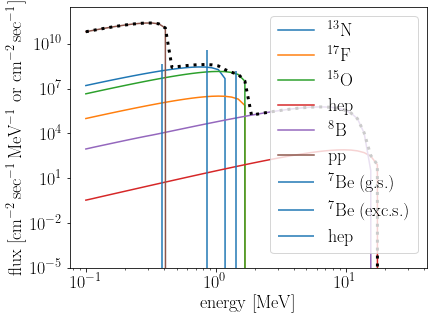

In [5]:
# spectra of continuous solar neutrino fluxes from http://www.sns.ias.edu/~jnb/
solar_spectrum_files = [ base_dir + "/solar-nu/" + f
                           for f in ["n13.dat", "f17.dat", "o15.dat", "hepspectrum.dat", 
                                     "b8spectrum.dat", "ppspectrum.dat"] ];
solar_spectrum_labels = [ r'${}^{13}$N', r'${}^{17}$F', r'${}^{15}$O',
                          r'hep', r'${}^{8}$B', 'pp' ]
solar_spectrum = [ np.loadtxt(f) for f in solar_spectrum_files ]
for x in solar_spectrum:
    x[:,0] *= u.MeV
    x[:,1] *= 1/u.MeV

# corresponding normalizations from https://arxiv.org/abs/astro-ph/0412440, Table 2, BS05(AGS,OP) model
solar_spectrum_norm  = np.array([ 2.01e8,         # N-13
                                  3.25e6,         # F-17
                                  1.45e8,         # O-15
                                  8.25e3,         # hep
                                  4.51e6,         # B-8
                                  6.06e10         # pp
                                ]) / (u.cm**2 * u.sec)
solar_spectrum_interp = [ interp.interp1d(s[:,0], norm * s[:,1], bounds_error=False, fill_value=0.)
                              for s, norm in zip(solar_spectrum, solar_spectrum_norm) ]

# energies of discrete solar neutrino lines
solar_line_energies = np.array([ 0.8618,  # Be-7 (ground state), http://www.sns.ias.edu/~jnb/SNdata/7belineshape.html
                                 0.3843,  # Be-7 (excited state)
                                 1.44     # pep, https://en.wikipedia.org/wiki/Proton%E2%80%93proton_chain_reaction
                               ]) * u.MeV
solar_line_norms    = np.array([ 0.897 * 4.34e9, # corresponding normalization,
                                 0.103 * 4.34e9, #  from https://arxiv.org/abs/astro-ph/0412440, Table 2, BS05(AGS,OP) model
                                         1.45e8
                               ]) / (u.cm**2 * u.sec)
solar_line_labels   = [ r'${}^{7}$Be (g.s.)', r'${}^{7}$Be (exc.s.)', 'hep']

# plot
E_range = np.logspace(-1,1.5) * u.MeV
for s, l in zip(solar_spectrum_interp, solar_spectrum_labels):
    plt.plot(E_range/u.MeV, s(E_range) * u.cm**2 * u.sec * u.MeV, label=l)
plt.plot(E_range/u.MeV, np.sum([s(E_range) * u.cm**2 * u.sec * u.MeV
                           for s in solar_spectrum_interp], axis=0), c='black', lw='3', ls=':')
for E, norm, l in zip(solar_line_energies, solar_line_norms, solar_line_labels):
    plt.vlines([E/u.MeV], ymin=1e-10, ymax=norm * u.cm**2 * u.sec, label=l)
plt.xlabel(r'energy [MeV]')
plt.ylabel(r'flux [cm$^{-2}$\,sec$^{-1}$\,MeV$^{-1}$ or cm$^{-2}$\,sec$^{-1}$]')
plt.xscale('log')
plt.yscale('log')
plt.ylim(bottom=1e-5)
plt.legend(loc='upper right')
plt.show()

### Atmospheric Neutrinos

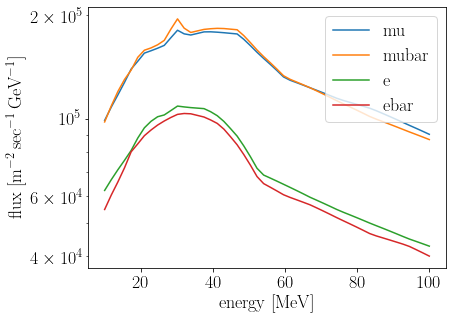

In [6]:
# Battistoni fluxes below 100 MeV
atm_spectrum_file   = base_dir + "/atm-nu/battistoni.dat"

atm_spectrum        = np.loadtxt(atm_spectrum_file)
atm_spectrum[:,0]  *= u.GeV
atm_spectrum[:,1:] *= 1 / (u.meter**2 * u.sec * u.GeV)

atm_flavors         = ['mu','mubar','e','ebar']
atm_spectrum_interp = { f: interp.interp1d(atm_spectrum[:,0], atm_spectrum[:,j], bounds_error=False, fill_value='extrapolate')
                              for j, f in zip(range(1,5), atm_flavors) }
atm_spectrum_interp['x']   = interp.interp1d(atm_spectrum[:,0], atm_spectrum[:,1] + atm_spectrum[:,2], bounds_error=False, fill_value='extrapolate')
atm_spectrum_interp['all'] = interp.interp1d(atm_spectrum[:,0], np.sum(atm_spectrum[:,1:],axis=1), bounds_error=False, fill_value='extrapolate')

# plot
E_range = np.linspace(10,100,50) * u.MeV
#E_range = np.logspace(1,2,50) * u.MeV
for f in atm_flavors:
    plt.plot(E_range/u.MeV, atm_spectrum_interp[f](E_range) * (u.meter**2 * u.sec * u.GeV),
             label=f)
plt.xlabel('energy [MeV]')
plt.ylabel('flux [m$^{-2}$\,sec$^{-1}$\,GeV$^{-1}$]')
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

### Diffuse Supernova Neutrinos

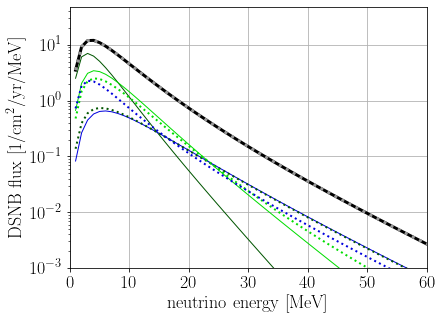

In [7]:
# diffuse supernova neutrino background - direct calculation
def phi_sn(f, E):
    '''supernova neutrino spectrum for flavor f and energy E
       https://arxiv.org/abs/hep-ph/0408031, eq. (2.4)'''
    dsnb_T    = { 'e':    3.5*u.MeV,   # spectrum temperature
                  'ebar': 5*u.MeV,
                  'x':    8*u.MeV }
    dsnb_eta  = { 'e':    2,           # pinching parameter
                  'ebar': 2,
                  'x':    1 }

    T   = dsnb_T[f]
    eta = dsnb_eta[f]
    return 1 / T**4 * E**2 / (np.exp(E/T - eta) + 1)

# normalization factor k_alpha from eq. 2.4
sn_norm = 3e53*u.erg / integ.quad(lambda E: E * (phi_sn('e', E) + phi_sn('ebar', E) + 4*phi_sn('x', E)),
                                  0, 100*u.MeV)[0]

# def R_SN(z):
#     '''supernova rate at redshift z
#        (https://arxiv.org/abs/hep-ph/0408031, eq. (2.3))'''
#     R0    = 2e-4 / u.yrs / u.Mpc**3
#     beta  = 2.5
#     alpha = 0.
#     if z <= 1:
#         return R0 * (1+z)**beta
#     else:
#         return R0 * 2**(beta - alpha) * (1+z)**alpha
    
def R_SN(z):
    '''supernova rate at redshift z
       (model SF2 from https://arxiv.org/abs/astro-ph/0202450, eqs. 5 and 8)'''
    return 0.0122 * 0.15 * np.exp(3.4*z) / (np.exp(3.4*z) + 22) / u.yrs / u.Mpc**3
    
def Hubble(z):
    '''Hubble parameter at redshift z
       (https://arxiv.org/abs/hep-ph/0408031, eq. (2.2))'''
    H0           = 70 * u.km / u.sec / u.Mpc
    Omega_m      = 0.3
    Omega_Lambda = 0.7
    return H0 * np.sqrt( Omega_m*(1+z)**3 + Omega_Lambda )
    
def my_phi_dsnb_unosc(f, E):
    '''unoscillated discrete supernova neutrino background at flavor f and energy E
       (https://arxiv.org/abs/hep-ph/0408031, eq. (2.1))'''
    return integ.quad(lambda z: R_SN(z) * sn_norm * phi_sn(f, E*(1+z)) / Hubble(z),
                      0, 5)[0]

def my_phi_dsnb_osc(f, E):
    '''discrete supernova neutrino background at flavor f and energy E
       including neutrino oscillations on the way out of the supernova.
       (https://arxiv.org/abs/hep-ph/0408031, eq. (2.1) and Table I)'''
    
    # mixing angles (NuFit 4.1)
    th12 = 33.82 * np.pi/180.
    th13 =  8.60 * np.pi/180.
    th23 = 48.6  * np.pi/180.
    
    # construct leptonic mixing matrix
    U = trafo.Rotation.from_euler('x', -th23).as_matrix() @ \
        trafo.Rotation.from_euler('y',  th13).as_matrix() @ \
        trafo.Rotation.from_euler('z', -th12).as_matrix()
    
    # note: at very high density, for normal mass ordering:
    #   \nu_e=\nu_3,         \nu_\mu=\nu_1,         \nu_\tau=\nu_2
    #   \bar\nu_e=\bar\nu_1, \bar\nu_\mu=\bar\nu_2, \bar\nu_\tau=\bar\nu_3
    if f == 'e':
        return np.abs(U[0,2])**2 * my_phi_dsnb_unosc('e', E) \
            + (np.abs(U[0,0])**2 + np.abs(U[0,1])**2) * my_phi_dsnb_unosc('x', E)
    elif f == 'ebar':
        return np.abs(U[0,0])**2 * my_phi_dsnb_unosc('ebar', E) \
            + (np.abs(U[0,1])**2 + np.abs(U[0,2])**2) * my_phi_dsnb_unosc('x', E)
    elif f == 'x':
        return 0.25 * (
               (np.abs(U[1,2])**2 + np.abs(U[2,2])**2) * my_phi_dsnb_unosc('e', E) \
             + (np.abs(U[1,0])**2 + np.abs(U[2,0])**2) * my_phi_dsnb_unosc('ebar', E) \
             + (np.abs(U[1,0])**2 + np.abs(U[2,0])**2 + np.abs(U[1,1])**2 + np.abs(U[2,1])**2 \
              + np.abs(U[1,1])**2 + np.abs(U[2,1])**2 + np.abs(U[1,2])**2 + np.abs(U[2,2])**2) \
                    * my_phi_dsnb_unosc('x', E) )
    elif f == 'all':
        return my_phi_dsnb_unosc('e', E) + my_phi_dsnb_unosc('ebar', E) + 4 * my_phi_dsnb_unosc('x', E)
    else:
        raise ValueError("invalid flavor: {:s}".format(f))

E_range = np.linspace(1, 100, 99) * u.MeV
plt.plot(E_range/u.MeV, [ (my_phi_dsnb_unosc('e', E)+my_phi_dsnb_unosc('ebar', E)+4*my_phi_dsnb_unosc('x', E)) * (u.cm**2 * u.sec * u.MeV) for E in E_range ], c='k', lw=3)
plt.plot(E_range/u.MeV, [ my_phi_dsnb_unosc('e', E)    * (u.cm**2 * u.sec * u.MeV) for E in E_range ], c='#005500', lw=1)
plt.plot(E_range/u.MeV, [ my_phi_dsnb_unosc('ebar', E) * (u.cm**2 * u.sec * u.MeV) for E in E_range ], c='#00dd00', lw=1)
plt.plot(E_range/u.MeV, [ my_phi_dsnb_unosc('x', E)    * (u.cm**2 * u.sec * u.MeV) for E in E_range ], c='#0000dd', lw=1)
plt.plot(E_range/u.MeV, [ (my_phi_dsnb_osc('e', E)+my_phi_dsnb_osc('ebar', E)+4*my_phi_dsnb_osc('x', E)) * (u.cm**2 * u.sec * u.MeV) for E in E_range ], c='#999999', lw=3, ls=':')
plt.plot(E_range/u.MeV, [ my_phi_dsnb_osc('e', E)      * (u.cm**2 * u.sec * u.MeV) for E in E_range ], c='#005500', ls=':', lw=2)
plt.plot(E_range/u.MeV, [ my_phi_dsnb_osc('ebar', E)   * (u.cm**2 * u.sec * u.MeV) for E in E_range ], c='#00dd00', ls=':', lw=2)
plt.plot(E_range/u.MeV, [ my_phi_dsnb_osc('x', E)      * (u.cm**2 * u.sec * u.MeV) for E in E_range ], c='#0000dd', ls=':', lw=2)
plt.yscale('log')
plt.xlabel('neutrino energy [MeV]')
plt.ylabel('DSNB flux [1/cm$^2$/yr/MeV]')
plt.grid()
plt.xlim(0,60)
plt.ylim(bottom=1e-3)
plt.show()

In [8]:
# diffuse supernova neutrino backgrounds - from https://arxiv.org/abs/1804.03157, fig. 3
dsnb_unit_conv          = lambda X: [X[0]*u.MeV, np.log(X[1]/u.cm**2/u.sec/u.MeV)]
dsnb_flux_nu_e_lower    = np.array([dsnb_unit_conv(X) for X in np.loadtxt('dsnb/dsnb-1804.03157-nu-e-lower.dat')])
dsnb_flux_nu_e_upper    = np.array([dsnb_unit_conv(X) for X in np.loadtxt('dsnb/dsnb-1804.03157-nu-e-upper.dat')])
dsnb_flux_nu_ebar_lower = np.array([dsnb_unit_conv(X) for X in np.loadtxt('dsnb/dsnb-1804.03157-nu-e-bar-lower.dat')])
dsnb_flux_nu_ebar_upper = np.array([dsnb_unit_conv(X) for X in np.loadtxt('dsnb/dsnb-1804.03157-nu-e-bar-upper.dat')])

dsnb_flux_nu_e_lower_interp    = interp.interp1d(*dsnb_flux_nu_e_lower.T, fill_value='extrapolate')
dsnb_flux_nu_e_upper_interp    = interp.interp1d(*dsnb_flux_nu_e_upper.T, fill_value='extrapolate')
dsnb_flux_nu_ebar_lower_interp = interp.interp1d(*dsnb_flux_nu_ebar_lower.T, fill_value='extrapolate')
dsnb_flux_nu_ebar_upper_interp = interp.interp1d(*dsnb_flux_nu_ebar_upper.T, fill_value='extrapolate')

def phi_dsnb_osc(f, E, which='mean'):
    '''Returns the oscillated diffuse supernova neutrino flux
       according to https://arxiv.org/abs/1804.03157, fig. 3
       
       Arguments:
           f: the neutrino flavor ('e' or 'ebar')
           E: neutrino energy
           which: 'lower', 'upper' or 'mean' '''

    if f == 'e':
        result = np.exp(np.array([dsnb_flux_nu_e_lower_interp(E),
                                  dsnb_flux_nu_e_upper_interp(E)]))
    elif f == 'ebar':
        result = np.exp(np.array([dsnb_flux_nu_ebar_lower_interp(E),
                                  dsnb_flux_nu_ebar_upper_interp(E)]))
    else:
        raise ValueError('Invalid flavor specification ({:s}). Only e and ebar are supported'.format(f))
        
    if which == 'lower':
        return result[0]
    elif which == 'upper':
        return result[1]
    elif which == 'mean':
        return 0.5 * (result[0] + result[1])
    else:
        raise ValueError('Invalid limit specification: {:s}'.format(which))


### Reactor Neutrinos

In [9]:
# Reactor \bar\nu_e
reactor_rate_SK = np.loadtxt('dsnb/reactor-0309300.dat')
reactor_rate_SK[:,0] *= u.MeV
reactor_rate_SK[:,1] *= 1/u.MeV/u.yrs

reactor_rate_SK_interp = interp.interp1d(reactor_rate_SK[:,0], np.log(reactor_rate_SK[:,1]), fill_value='extrapolate')

## Monte Carlo Simulation

### Preliminary Tests: Muon Decays

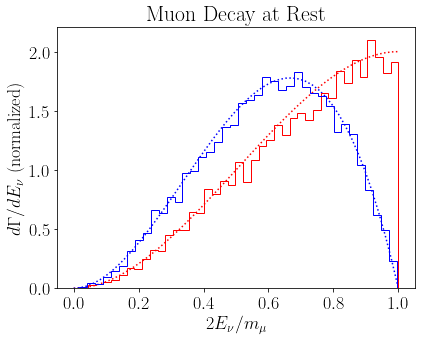

In [11]:
# muon decay at rest
nn=10000
n_bins=40
E_nu_table = process_mu_decay_at_rest()
x_range = np.linspace(0, 1, 50)
plt.plot(x_range, 2 * x_range**2*(3-2*x_range), ls=':', c='red')
plt.plot(x_range, 2 * 6*x_range**2*(1-x_range), ls=':', c='blue')
plt.hist(2*E_nu_table[::2]/u.m_mu,  bins=n_bins, weights=np.full(len(E_nu_table)//2, n_bins/nn),
         histtype='step', color='red' )
plt.hist(2*E_nu_table[1::2]/u.m_mu, bins=n_bins, weights=np.full(len(E_nu_table)//2, n_bins/nn),
         histtype='step', color='blue' )
plt.xlabel(r'$2 E_\nu/m_\mu$')
plt.ylabel(r'$d\Gamma/dE_\nu$ (normalized)')
plt.title('Muon Decay at Rest')
plt.show()

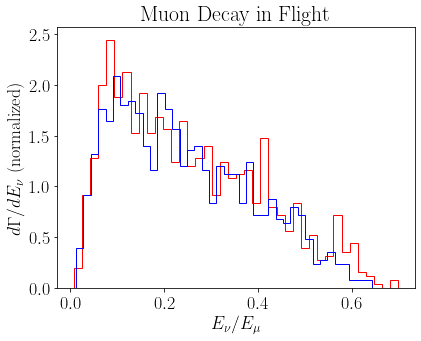

In [107]:
# decay of energetic muons with a degenerate electron background
nn     = 1000
n_bins =  40
E_mu   = 210*u.MeV
kfe    =  60*u.MeV
E_mu_table = np.full((nn), E_mu)
kfe_table  = np.full((nn),  kfe)
E_nu_table = process_mu_decay(E_mu_table, kfe_table)
x_range = np.linspace(0, 1, 50)
plt.hist(E_nu_table[::2]/E_mu,  bins=n_bins, weights=np.full(len(E_nu_table)//2, n_bins/nn),
         histtype='step', color='red' )
plt.hist(E_nu_table[1::2]/E_mu, bins=n_bins, weights=np.full(len(E_nu_table)//2, n_bins/nn),
         histtype='step', color='blue' )
plt.xlabel(r'$E_\nu/E_\mu$')
plt.ylabel(r'$d\Gamma/dE_\nu$ (normalized)')
plt.title('Muon Decay in Flight')
plt.show()

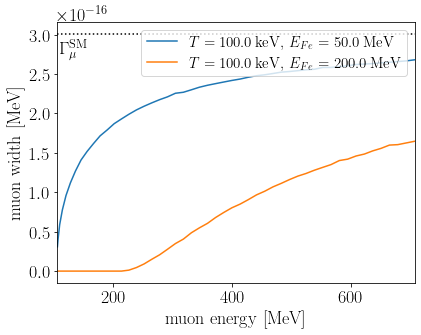

In [89]:
# muon decay width in high-density environment
nscool_dir = base_dir + f'/packages/nscool/results/scan-BSk22/run-M1.8/'
mp = muon_propagator(nscool_dir, 'mu-width-table.dat')
T_table    = np.array([100,100]) * u.keV
mu_e_table = np.array([50,200]) * u.MeV
p_mu_table = np.linspace(0, 700, 50) * u.MeV
E_mu_table = np.sqrt(p_mu_table**2 + u.m_mu**2)

mu_width_table        = np.array([[mu_width(p_mu, mu_e, T) for p_mu in p_mu_table] for T,mu_e in zip(T_table,mu_e_table)])
mu_width_interp_table = np.array([[mp.mu_width_interp((p_mu, mu_e, T)) for p_mu in p_mu_table] for T,mu_e in zip(T_table,mu_e_table)])
for j in range(len(T_table)):
    plt.plot(E_mu_table/u.MeV, mu_width_table[j] * E_mu_table/u.m_mu/u.MeV, label=f'$T = {T_table[j]/u.keV}$\,keV, $E_{{Fe}}$ = {mu_e_table[j]/u.MeV}\,MeV')
#plt.plot(E_mu_table/u.MeV, mu_width_interp_table * E_mu_table/u.m_mu/u.MeV)
plt.xlabel('muon energy [MeV]')
plt.ylabel('muon width [MeV]')
#plt.axvline(mu_e/u.MeV, c='k', ls=':')
#plt.annotate(r'$E_{Fe}$', (1.05*mu_e/u.MeV, 0.5*mu_width_SM/u.MeV), rotation=90, ha='left', va='top')
plt.axhline(mu_width_SM/u.MeV, c='k', ls=':')
plt.annotate(r'$\Gamma_\mu^\text{SM}$', (1.03*E_mu_table[0]/u.MeV, 0.98*mu_width_SM/u.MeV), ha='left', va='top')
plt.legend(loc='upper right', fontsize=15)
plt.xlim(E_mu_table[0]/u.MeV, E_mu_table[-1]/u.MeV)
#plt.yscale('log')
plt.show()

### Run Monte Carlo

In [ ]:
# Run Monte Carlo - multiple processors
def run_muon_propagator(eos_MM):
    """wrapper function called by each subprocess"""
    N_samples   = 15000
    n_t_bins    = 15
    t_min       = 1e3*u.yrs  # time window in which muons are generated
    t_min       = 1e1*u.yrs  # time window in which muons are generated # FIXME FIXME
    t_max       = 0.999e6*u.yrs # for some runs, 1e6 yrs is the last sample; by setting t_max a bit smaller, we avoid out-of-bounds errors
    t_bin_edges = np.transpose((lambda x: [x, x+100*u.yrs])(np.logspace(np.log10(t_min), np.log10(t_max), n_t_bins+1)))
    
    eos = eos_MM[0]
    MM  = eos_MM[1]
    print(f'Running for {eos}, M={MM} M_sun ...\n', end='')
    
    # Load NSCool output
    nscool_dir = base_dir + f'/packages/nscool/results/scan-{eos}/run-{MM}/'
    mp = muon_propagator(nscool_dir, 'mu-width-table.dat')
    
    # Run simulation
    rnd.seed(1007) # FIXME FIXME
    mp.simulate_muons_vectorized(N_samples=N_samples, t_bin_edges=t_bin_edges,
                                 dr_min=50*u.m, dr_max=500*u.m, tolerance=0.1, verbosity=1,
                                 include_amd='partial', # FIXME FIXME
                                 log_file=nscool_dir+'/ns-muons.log')

    # store output
    with open(nscool_dir + '/ns-muons.dat', 'wb') as f:
        pickle.dump(mp, f) 
    print(f'done for {eos}, M={MM} M_sun ...')
    
import multiprocess
import functools
import inspect
import time
import importlib

# write wrapper function to external file to allow multiprocessing from within Jupyter notebook
# (see https://newbedev.com/jupyter-notebook-never-finishes-processing-using-multiprocessing-python-3)
with open(base_dir + '/tmp_func.py', 'w') as file:
    file.write('from muon_propagator import *\n')
    file.write('import numpy as np\n')
    file.write('import pickle\n')
    file.write(inspect.getsource(run_muon_propagator).replace(run_muon_propagator.__name__, 'task')
                                                     .replace('base_dir', "'"+base_dir+"'"))
import tmp_func
tmp_func = importlib.reload(tmp_func)

#MM_table  = [1.0,1.2,1.4,1.6,1.8,2.0]
eos_table = ['cat','BSk22','BSk24','BSk25','BSk26','MF-B0','nl3wr']
MM_table  = [2.0]
MM_table   = [f'{M}' for M in MM_table]
if __name__ == '__main__':
    with multiprocess.Pool(processes=4) as pool: # FIXME
        r = pool.map(tmp_func.task, [[eos, MM] for eos in eos_table for MM in MM_table])
        
#        r = pool.map_async(tmp_func.task, [[eos, MM] for eos in eos_table for MM in MM_table])
#        while not r.ready():
#            sys.stdout.flush()
#            r.wait(0.1)
#        results = [pool.apply_async(task, (x,)) for x in [[eos, MM] for eos in eos_table for MM in MM_table]]
#        print([r.get() for r  in results])
#        print(pool.imap(ff, range(10)))
#        pool.map(run_muon_propagator, [[eos, MM] for eos in eos_table for MM in MM_table])

Running for BSk25, M=2.0 M_sun ...
Running for BSk24, M=2.0 M_sun ...
Running for cat, M=2.0 M_sun ...
Running for BSk22, M=2.0 M_sun ...


/Users/jkopp/Dropbox (Personal)/ns-muons/jk/muon_propagator.py:1359: RuntimeWarning: divide by zero encountered in divide
  * kfmu**2 * T / ( 2*np.pi**2 * (1 + np.exp(-mumu/T))**2 )


starting main loop .. Sun Dec 10 00:41:46 2023


/Users/jkopp/Dropbox (Personal)/ns-muons/jk/muon_propagator.py:1564: RuntimeWarning: overflow encountered in exp
  return np.exp(x) / (1 + np.exp(x))**2
/Users/jkopp/Dropbox (Personal)/ns-muons/jk/muon_propagator.py:1564: RuntimeWarning: overflow encountered in square
  return np.exp(x) / (1 + np.exp(x))**2
/Users/jkopp/Dropbox (Personal)/ns-muons/jk/muon_propagator.py:1359: RuntimeWarning: divide by zero encountered in divide
  * kfmu**2 * T / ( 2*np.pi**2 * (1 + np.exp(-mumu/T))**2 )
/Users/jkopp/Dropbox (Personal)/ns-muons/jk/muon_propagator.py:1359: RuntimeWarning: divide by zero encountered in divide
  * kfmu**2 * T / ( 2*np.pi**2 * (1 + np.exp(-mumu/T))**2 )
/Users/jkopp/Dropbox (Personal)/ns-muons/jk/muon_propagator.py:1359: RuntimeWarning: divide by zero encountered in divide
  * kfmu**2 * T / ( 2*np.pi**2 * (1 + np.exp(-mumu/T))**2 )


starting main loop ..starting main loop ..  Sun Dec 10 00:41:46 2023Sun Dec 10 00:41:46 2023



/Users/jkopp/Dropbox (Personal)/ns-muons/jk/muon_propagator.py:1564: RuntimeWarning: overflow encountered in exp
  return np.exp(x) / (1 + np.exp(x))**2
/Users/jkopp/Dropbox (Personal)/ns-muons/jk/muon_propagator.py:1564: RuntimeWarning: overflow encountered in exp
  return np.exp(x) / (1 + np.exp(x))**2
/Users/jkopp/Dropbox (Personal)/ns-muons/jk/muon_propagator.py:1564: RuntimeWarning: overflow encountered in square
  return np.exp(x) / (1 + np.exp(x))**2
/Users/jkopp/Dropbox (Personal)/ns-muons/jk/muon_propagator.py:1564: RuntimeWarning: overflow encountered in square
  return np.exp(x) / (1 + np.exp(x))**2


starting main loop .. Sun Dec 10 00:41:46 2023


/Users/jkopp/Dropbox (Personal)/ns-muons/jk/muon_propagator.py:1564: RuntimeWarning: overflow encountered in exp
  return np.exp(x) / (1 + np.exp(x))**2
/Users/jkopp/Dropbox (Personal)/ns-muons/jk/muon_propagator.py:1564: RuntimeWarning: overflow encountered in square
  return np.exp(x) / (1 + np.exp(x))**2


In [27]:
M = 2.0
eos = 'BSk24'
mp = load_mp(base_dir + f'/packages/nscool/results/scan-{eos}/run-{M}/ns-muons.dat', compute_totals=False, verbosity=1)
n_tot = len(mp.t_decay_table) + len(mp.t_loss_table) + len(mp.t_survivor_table)
print('{:s} M={:f} M_sun: {:d} events read ({:d} decaying ({:f}%), {:d} absorbed ({:f}%)).'.format(
      eos, M, n_tot,
      len(mp.t_decay_table), 100*len(mp.t_decay_table)/n_tot, len(mp.t_loss_table), 100*len(mp.t_loss_table)/n_tot))

  i       t       abs      dec     surv     tau         f
        [yrs]                              [yrs]         
   0      60        1        0        0     1.62 61.8256
   1      72        1        0        0     1.46 68.4807
   2      96    0.996  0.00427        0     1.33 75.1016
   3 1.5e+02    0.879    0.121        0     1.86 53.6538
   4 2.7e+02    0.882    0.118        0     1.23 81.3528
   5 5.1e+02     0.85     0.15        0     1.22 81.6416
   6   1e+03    0.884    0.116        0     1.18 84.8173
   7 2.2e+03    0.862    0.138        0     1.12 89.1716
   8 4.7e+03    0.854    0.146        0     1.07 93.0499
   9   1e+04    0.841    0.159        0    0.989 101.145
  10 2.2e+04     0.84     0.16        0     1.04 95.7555
  11 4.6e+04    0.825    0.175        0    0.681   146.8
  12   1e+05      0.8      0.2        0    0.683 146.392
  13 2.2e+05    0.694    0.306        0     0.67  149.22
  14 4.6e+05    0.505    0.495        0    0.345 289.963
BSk24 M=2.000000 M_sun: 13493

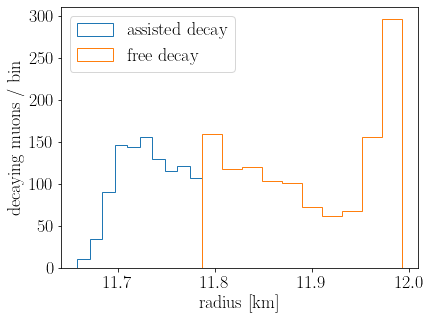

In [28]:
i1 = (np.array(mp.decay_mode_table)=='a')
i2 = (np.array(mp.decay_mode_table)=='f')
plt.hist(mp.r_decay_table[i1]/u.km, histtype='step', label='assisted decay')
plt.hist(mp.r_decay_table[i2]/u.km, histtype='step', label='free decay')
plt.legend(loc='upper left')
plt.xlabel('radius [km]')
plt.ylabel('decaying muons / bin')
plt.show()

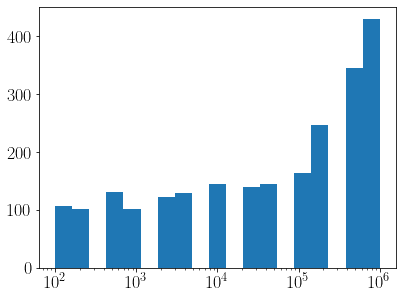

In [29]:
plt.hist(mp.t_decay_table/u.yrs,bins=np.logspace(2,6,20))
plt.xscale('log')

Text(0, 0.5, 'numbe of absorbed muons')

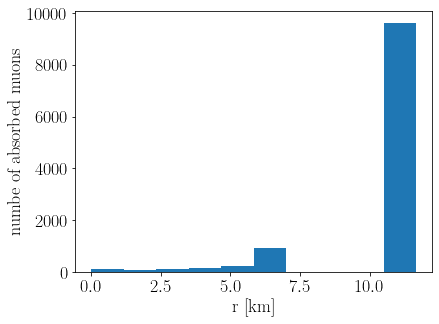

In [30]:
plt.hist(mp.r_loss_table/u.km)
plt.xlabel('r [km]')
plt.ylabel('numbe of absorbed muons')

### Neutrino Fluxes

cat M=1.200000 M_sun: 13493 events read (64 decaying, 13425 absorbed).
BSk22 M=1.200000 M_sun: 13493 events read (25 decaying, 13468 absorbed).


<ipython-input-30-79cb333bbe31>:301: RuntimeWarning: divide by zero encountered in scalar divide
  nu_spectra[i,j,k] *= 1/u.sec / np.sum(nu_spectra[i,j,k]) \
<ipython-input-30-79cb333bbe31>:301: RuntimeWarning: invalid value encountered in multiply
  nu_spectra[i,j,k] *= 1/u.sec / np.sum(nu_spectra[i,j,k]) \


BSk24 M=1.200000 M_sun: 13493 events read (94 decaying, 13398 absorbed).
BSk25 M=1.200000 M_sun: 13493 events read (314 decaying, 13178 absorbed).
BSk26 M=1.200000 M_sun: 13493 events read (170 decaying, 13319 absorbed).
nl3wr M=1.200000 M_sun: 13493 events read (10 decaying, 13483 absorbed).
cat M=1.400000 M_sun: 135001 events read (2042 decaying, 132843 absorbed).
BSk22 M=1.400000 M_sun: 135001 events read (1372 decaying, 133629 absorbed).
BSk24 M=1.400000 M_sun: 135001 events read (2016 decaying, 132893 absorbed).
BSk25 M=1.400000 M_sun: 135001 events read (4698 decaying, 130209 absorbed).
BSk26 M=1.400000 M_sun: 135001 events read (3162 decaying, 131720 absorbed).
nl3wr M=1.400000 M_sun: 135001 events read (216 decaying, 134785 absorbed).
cat M=1.600000 M_sun: 13493 events read (308 decaying, 13167 absorbed).
BSk22 M=1.600000 M_sun: 13493 events read (252 decaying, 13241 absorbed).
BSk24 M=1.600000 M_sun: 13493 events read (201 decaying, 13275 absorbed).
BSk25 M=1.600000 M_sun: 134

<ipython-input-7-bc80945d8516>:83: RuntimeWarning: invalid value encountered in divide
  return (r_abs+r_dec) * 1/tau * np.exp(-(t - mp.t_bin_edges[i,0])/tau) \


BSk25 M=2.000000 M_sun: 13493 events read (2471 decaying, 11022 absorbed).
BSk26 M=2.000000 M_sun: 13493 events read (421 decaying, 13072 absorbed).
nl3wr M=2.000000 M_sun: 13493 events read (3824 decaying, 9669 absorbed).


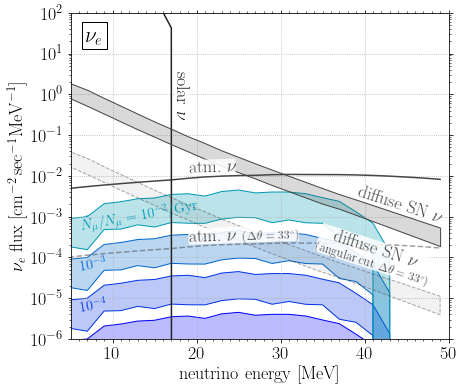

cat M=1.200000 M_sun: 13493 events read (64 decaying, 13425 absorbed).
BSk22 M=1.200000 M_sun: 13493 events read (25 decaying, 13468 absorbed).
BSk24 M=1.200000 M_sun: 13493 events read (94 decaying, 13398 absorbed).


<ipython-input-30-79cb333bbe31>:301: RuntimeWarning: divide by zero encountered in scalar divide
  nu_spectra[i,j,k] *= 1/u.sec / np.sum(nu_spectra[i,j,k]) \
<ipython-input-30-79cb333bbe31>:301: RuntimeWarning: invalid value encountered in multiply
  nu_spectra[i,j,k] *= 1/u.sec / np.sum(nu_spectra[i,j,k]) \


BSk25 M=1.200000 M_sun: 13493 events read (314 decaying, 13178 absorbed).
BSk26 M=1.200000 M_sun: 13493 events read (170 decaying, 13319 absorbed).
nl3wr M=1.200000 M_sun: 13493 events read (10 decaying, 13483 absorbed).
cat M=1.400000 M_sun: 135001 events read (2042 decaying, 132843 absorbed).
BSk22 M=1.400000 M_sun: 135001 events read (1372 decaying, 133629 absorbed).
BSk24 M=1.400000 M_sun: 135001 events read (2016 decaying, 132893 absorbed).
BSk25 M=1.400000 M_sun: 135001 events read (4698 decaying, 130209 absorbed).
BSk26 M=1.400000 M_sun: 135001 events read (3162 decaying, 131720 absorbed).
nl3wr M=1.400000 M_sun: 135001 events read (216 decaying, 134785 absorbed).
cat M=1.600000 M_sun: 13493 events read (308 decaying, 13167 absorbed).
BSk22 M=1.600000 M_sun: 13493 events read (252 decaying, 13241 absorbed).
BSk24 M=1.600000 M_sun: 13493 events read (201 decaying, 13275 absorbed).
BSk25 M=1.600000 M_sun: 13493 events read (419 decaying, 13056 absorbed).
BSk26 M=1.600000 M_sun: 13

<ipython-input-7-bc80945d8516>:83: RuntimeWarning: invalid value encountered in divide
  return (r_abs+r_dec) * 1/tau * np.exp(-(t - mp.t_bin_edges[i,0])/tau) \


BSk25 M=2.000000 M_sun: 13493 events read (2471 decaying, 11022 absorbed).
BSk26 M=2.000000 M_sun: 13493 events read (421 decaying, 13072 absorbed).
nl3wr M=2.000000 M_sun: 13493 events read (3824 decaying, 9669 absorbed).


<ipython-input-30-79cb333bbe31>:556: RuntimeWarning: divide by zero encountered in divide
  ax.plot(E_nu_bin_centers/u.MeV, np.exp(reactor_rate_SK_interp(E_nu_bin_centers))


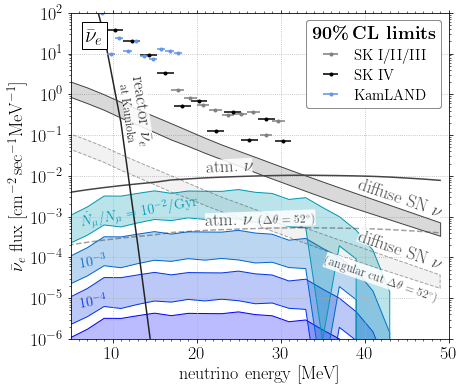

cat M=1.200000 M_sun: 13493 events read (64 decaying, 13425 absorbed).
BSk22 M=1.200000 M_sun: 13493 events read (25 decaying, 13468 absorbed).


<ipython-input-30-79cb333bbe31>:301: RuntimeWarning: divide by zero encountered in scalar divide
  nu_spectra[i,j,k] *= 1/u.sec / np.sum(nu_spectra[i,j,k]) \
<ipython-input-30-79cb333bbe31>:301: RuntimeWarning: invalid value encountered in multiply
  nu_spectra[i,j,k] *= 1/u.sec / np.sum(nu_spectra[i,j,k]) \


BSk24 M=1.200000 M_sun: 13493 events read (94 decaying, 13398 absorbed).
BSk25 M=1.200000 M_sun: 13493 events read (314 decaying, 13178 absorbed).
BSk26 M=1.200000 M_sun: 13493 events read (170 decaying, 13319 absorbed).
nl3wr M=1.200000 M_sun: 13493 events read (10 decaying, 13483 absorbed).
cat M=1.400000 M_sun: 135001 events read (2042 decaying, 132843 absorbed).
BSk22 M=1.400000 M_sun: 135001 events read (1372 decaying, 133629 absorbed).
BSk24 M=1.400000 M_sun: 135001 events read (2016 decaying, 132893 absorbed).
BSk25 M=1.400000 M_sun: 135001 events read (4698 decaying, 130209 absorbed).
BSk26 M=1.400000 M_sun: 135001 events read (3162 decaying, 131720 absorbed).
nl3wr M=1.400000 M_sun: 135001 events read (216 decaying, 134785 absorbed).
cat M=1.600000 M_sun: 13493 events read (308 decaying, 13167 absorbed).
BSk22 M=1.600000 M_sun: 13493 events read (252 decaying, 13241 absorbed).
BSk24 M=1.600000 M_sun: 13493 events read (201 decaying, 13275 absorbed).
BSk25 M=1.600000 M_sun: 134

<ipython-input-7-bc80945d8516>:83: RuntimeWarning: invalid value encountered in divide
  return (r_abs+r_dec) * 1/tau * np.exp(-(t - mp.t_bin_edges[i,0])/tau) \


BSk26 M=2.000000 M_sun: 13493 events read (421 decaying, 13072 absorbed).
nl3wr M=2.000000 M_sun: 13493 events read (3824 decaying, 9669 absorbed).


In [ ]:
# the main function that generates our beautiful propaganda plots
def flux_plot(M_table, eos_table, flavor, norm='atnf', verbosity=0,
              plot_elements=['single-ns','pseudo-galaxies','backgrounds'], output=False):
    """create the "propaganda plots" of neutrino energy spectra.
    
       Parameters:
           M_table:       list of neutron star masses in M_sun
           eos_table:     list of equations of state to consider
           flavor:        neutrino flavor (e, ebar, x, or all)
           norm:          if this ia a float, it is interpreted as a total rate of muon decays,
                          and the neutrino spectrum is normalized by hand to this
                          rate (the neutrino production rate is then 2*norm)
                          if it is a string, it can have the following values:
                            'atnf': compute number of muon decays based on pulsars from the ATNF catalogue
                            'simple': a simpler estimate for the number of muon decays
           plot_elements: a list of elements to include in the plot. can be a combination of
                          the following:
                             'single-ns':        spectra from single NS
                             'pseudogalaxies':   integrated flux from the Milky Way, drawn as a band
                                                 representing the expected spread
                             'backgrounds':      plot backgrounds
                             'data' or 'limits': experimental limits (only for \bar\nu_e)
           output:        True:  write plot to file
                          False: only display plot on screen
           verbosity:     if >0, print extra messages to track progress"""

    if not hasattr(M_table, '__iter__'):
        M_table = [M_table]
    M_table = np.array(M_table)
    if not hasattr(eos_table, '__iter__') or type(eos_table)==str:
        eos_table = [eos_table]
    eos_table = np.array(eos_table)
    
    # properties of pseudo-galaxy population
    pseudo_galaxies_CL = 0.68               # what fraction of pseudo-galaxies to include in the band we show
    sn_rate            = 1.63 / (100*u.yrs) # MW SN rate, see https://arxiv.org/abs/2009.03438
    sn_rate_error      = 0.46 / (100*u.yrs)
    mw_disk_thickness  = 1000*u.ly          # thickness of MW stellar disk
    mw_age             = 13.6e9 * u.yrs     # age of Milky Way
    n_pseudo_galaxies  = 1000               # number of pseudo-populations to generate
    max_ns             = 10000              # max number of neutron stars to generate for each toy galaxy

    
    # properties of the Milky Way's neutron star population
    # note that the following table contains only pulsars with period > 0.03 (non-MSPs).
    # we assume that the muon population in MSPs goes out of equilibrium during spin-up,
    # so during spin-down it will just return to equilibrium, not expel muons
    pulsar_data         = pd.read_csv(f'{base_dir}/pulsar-data.dat', comment='#', delim_whitespace=True, index_col=0)
    pulsar_data['P0']  *= u.sec
    pulsar_data['dP0'] *= u.sec
    pulsar_data['d']   *= u.kpc
    pulsar_data['age'] *= u.yrs
    pulsar_data         = pulsar_data[pulsar_data['age'] > 1e4*u.yrs]  # in younger NSs, muons can't diffuse out yet
    n_ns_max            = 1e9
    n_ns_min            = 1e8
    n_pulsar_max        = n_ns_max/len(pulsar_data) * np.sum(2*pulsar_data['age'] / mw_age)
    n_pulsar_min        = n_ns_min/len(pulsar_data) * np.sum(2*pulsar_data['age'] / mw_age)
                                     # max./min. number of NS in the MW. In https://arxiv.org/abs/0908.3182,
                                     # that range is quoted as 1e8...1e9. But many of these will have spun down
                                     #   already and will therefore not contribute to the neutrino signal.
                                     #   We therefore use a different estimate, weighting each ATNF pulsars
                                     #   according to the time during which it contributes to the signal
    P_ini_min           = 0.01*u.sec # minimum/maximum initial spin periods of newly born neutron stars,
    P_ini_max           = 0.1*u.sec  #   based on 2104.07493, astro-ph/0409013, 1303.5258, 1301.1265, 1204.0632, see also 
    
    dV_600       = 0.002       # change in neutron star volume \Delta V/V for rotation with \Omega = 600 Hz
                               #   see section on EOS -> Shape of Magnetic and Rotating NS
    dV_600_min   = 0.001       # our guess, based again on the section on EOS -> Shape of Magnetic and Rotating NS
    dV_600_max   = 0.005
    
    # properties of neutron star binaries in the Milky Way
    n_binary_min = 1e5   # these are random numbers FIXME FIXME FIXME
    n_binary_max = 1e8   # need to replace!!!
    ttm_min      = 1e5*u.yrs   # time-to-merger; we set this equal to the inverse of the
                               # estimated merger rate in the MW from https://doi.org/10.1093/mnras/283.2.L37
                               # to ensure that at any given time there is at least one source
                               # at the lowest separation (from where most of the muon loss will come)
    ttm_max      = 1e9*u.yrs # FIXME check that dependence on this parameter is weak
    
    # properties of accreting neutron stars
    acc_rate_edd = 1.26e38 / 0.1 * u.erg/u.sec # the Eddington rate for a 1 M_sun neutron star                                
    acc_rate_min = acc_rate_edd / 100.
    acc_rate_avg = acc_rate_edd / 10.
    acc_rate_max = acc_rate_edd
    
    # detector properties
    m_SuperK     = 22.5e3 * u.tons
    m_HyperK     =  260e3 * u.tons   # fiducial detector mass for HyperKamiokande
    m_DUNE       =   40e3 * u.tons   # fiducial detector mass for DUNE
    dtheta_e     = 33*np.pi/180.     # estimated angular resolution for neutrino-electro scattering [rad]
    dtheta_ebar  = 52*np.pi/180.     #   based on calculation in urca.nb, see also resolution in E225 at LAMPF,
    dtheta_x     = 39*np.pi/180.     #   Raedel & Beyer, https://inspirehep.net/literature/355695

    # plot ranges
    t_bin_edges      = np.array([1e3, 1e4, 1e5, 1e6]) * u.yrs
    t_bin_centers    = 0.5 * (t_bin_edges[1:] + t_bin_edges[:-1])
    t_bin_widths     = np.diff(t_bin_edges)
    E_nu_bin_edges   = np.linspace(0,50.,26) * u.MeV       # for signal histograms
    if 'single-ns' in plot_elements and len(plot_elements) == 1:
        E_nu_bin_edges = np.linspace(0,50.,11) * u.MeV
    E_nu_bin_centers = 0.5 * (E_nu_bin_edges[1:] + E_nu_bin_edges[:-1])
    E_nu_bin_widths  = np.diff(E_nu_bin_edges)

    # plot styles
    my_colors = { 1.0: TO_colors[2],
                  1.2: TO_colors[5],
                  1.4: TO_colors[0],
                  1.6: TO_colors[3],
                  1.8: TO_colors[4],
                  2.0: TO_colors[1]}
    my_ls     = { 'cat':    '-',
                  'BSk22':  ':',
                  'BSk24':  '-.',
                  'BSk25':  '--',
                  'BSk26':  (0, (3, 2, 1, 2, 1, 2, 1, 2)),
                  'MF-B0':  (0, (3, 2, 3, 2, 1, 2, 1, 2)),
#                  'MF-B30': ':',
#                  'MF-B31': '--',
#                  'MF-B32': '-.',
                  'nl3wr':  (0, (3, 2, 1, 2, 1, 2)) 
                }

    # load external data / initialize
    # -------------------------------

    # interaction cross sections
    xsec_dir   = base_dir + '/packages/snowglobes/xscns/'
    xsec_files = { 'e':      xsec_dir + '/xs_nue_Ar40.dat',
    #               'e':      xsec_dir + '/xs_nue_e.dat',
                   'mu':     xsec_dir + '/xs_numu_e.dat',
                   'tau':    xsec_dir + '/xs_nutau_e.dat',
                   'ebar':   xsec_dir + '/xs_ibd.dat',
    #               'ebar':   xsec_dir + '/xs_nuebar_e.dat',
                   'mubar':  xsec_dir + '/xs_numu_e.dat',
                   'taubar': xsec_dir + '/xs_nutau_e.dat' }
    xsec_data = {}
    sigma     = {}
    for j, f in enumerate(xsec_files):
        xsec_data[f] = np.loadtxt(xsec_files[f])
        xsec_data[f][:,0]   = 10**xsec_data[f][:,0] * u.GeV
        xsec_data[f][:,1:] *= 1e-38 * u.cm**2 / u.GeV
        sigma[f] = interp.interp1d(xsec_data[f][:,0], xsec_data[f][:,0] * xsec_data[f][:,j+1],
                                   bounds_error=False, fill_value=0.)
    data_sk4     = np.loadtxt('dsnb/dsnb-2109.11174-sk4.dat')
    data_sk123   = np.loadtxt('dsnb/dsnb-2109.11174-sk123.dat')
    data_kamland = np.loadtxt('dsnb/dsnb-2109.11174-kamland.dat')

    # setup plot grid
    fig = plt.figure(figsize=(7,6))
    ax  = fig.gca()

    # load simulation output, compute event rates, and plot them
    # ----------------------------------------------------------

    nu_spectra    = np.zeros((len(M_table),len(eos_table),len(t_bin_centers),len(E_nu_bin_centers)))
    norm_spindown = {}
    norm_tidal    = {}
    norm_acc      = {}
    N_mu_spindown = {}
    N_mu_tidal    = {}
    N_mu_acc      = {}
    N_mu_0        = {}
    for i, M in enumerate(M_table):
        for j, eos in enumerate(eos_table):
            # in cases, where we have separate runs for the small-R and large-R branches, pick the small-R branch
            nscool_dir  = base_dir + f'/packages/nscool/results/scan-{eos}/run-smallR-M{M}/'
            if not os.path.exists(nscool_dir):
                nscool_dir  = base_dir + f'/packages/nscool/results/scan-{eos}/run-{M}/'
            nscool_dir  = base_dir + f'/packages/nscool/results/scan-{eos}/run-{M}/'
            nscool_file = nscool_dir + '/ns-muons.dat'
            try:
                mp = load_mp(nscool_file, compute_totals=False)
                if verbosity > 0:
                    print('{:s} M={:f} M_sun: {:d} events read ({:d} decaying, {:d} absorbed).'.format(
                          eos, M, len(mp.t_decay_table) + len(mp.t_loss_table) + len(mp.t_survivor_table), len(mp.t_decay_table), len(mp.t_loss_table)))
            except FileNotFoundError:
                print('{:s} M={:f} M_sun: file not found, assuming vanishing rates'.format(
                      eos, M))
                continue

            # compute normalization factor:
            # if the user has given us a by-hand normalization of the spectrum, apply it.
            if type(norm) == float or type(norm) == int:
                norm_spindown[eos,M] = norm
                norm_tidal[eos,M]    = norm
                norm_acc[eos,M]      = norm

            # Otherwise, estimate the normalization factor based on what we know about pulsars
            else:
                N_mu_0[eos,M] = integ.trapz(x=mp.star_data[:,k_r], y=4*np.pi * mp.star_data[:,k_r]**2 
                                       * mp.eos_data_core_interp[l_Ymu](mp.star_data[:,k_rho])
                                       * mp.eos_data_core_interp[l_nbar](mp.star_data[:,k_rho]))
                                    
                # normalization for tidal deformation case
                M1                = M * u.Msun
                M2                = 1.4*u.Msun
                ttm_table         = np.array([ttm_min, ttm_max])
                dV_tidal          = dV_600 / (2*np.pi*600*u.Hz)**2 / mp.R_NS \
                                      / np.sqrt((256./5.) * u.GN * M1/M2 * (M1+M2) * ttm_table)
                delta_rho_tidal   = 1 / (1 + dV_tidal) - 1
                N_mu_tidal[eos,M] = np.array([ 1/(1+drho) * integ.trapz(x=mp.star_data[:,k_r], y=4*np.pi * mp.star_data[:,k_r]**2 
                                         * mp.eos_data_core_interp[l_Ymu]((1+drho)*mp.star_data[:,k_rho]) 
                                         * mp.eos_data_core_interp[l_nbar]((1+drho)*mp.star_data[:,k_rho]))
                                               for drho in delta_rho_tidal ])
                norm_tidal[eos,M] = (N_mu_tidal[eos,M][-1] - N_mu_tidal[eos,M][0]) / (ttm_max - ttm_min)
                
            # extract \nu_e and \bar\nu_e spectra
            for k in range(len(t_bin_centers)):
                ii = np.where( (t_bin_edges[k] < mp.t_decay_table) & (mp.t_decay_table <= t_bin_edges[k+1]) )[0]

                if flavor == 'e':
                    w = mp.rate_decay_table_e[ii] / t_bin_widths[k]
                    nu_spectra[i,j,k] = np.histogram(mp.E_nu_table_rs[::2][ii]/u.MeV, bins=E_nu_bin_edges/u.MeV, weights=w)[0]
                elif flavor == 'ebar':
                    w = mp.rate_decay_table_ebar[ii] / t_bin_widths[k]
                    nu_spectra[i,j,k] = np.histogram(mp.E_nu_table_rs[1::2][ii]/u.MeV, bins=E_nu_bin_edges/u.MeV, weights=w)[0]
                elif flavor == 'x':
                    w1 = (mp.rate_decay_table[ii] - mp.rate_decay_table_e[ii]) / t_bin_widths[k]
                    w2 = (mp.rate_decay_table[ii] - mp.rate_decay_table_ebar[ii]) / t_bin_widths[k]
                    nu_spectra[i,j,k] = np.histogram(mp.E_nu_table_rs[::2][ii]/u.MeV, bins=E_nu_bin_edges/u.MeV, weights=w1)[0] \
                                      + np.histogram(mp.E_nu_table_rs[1::2][ii]/u.MeV, bins=E_nu_bin_edges/u.MeV, weights=w2)[0]
                elif flavor == 'all':
                    w = mp.rate_decay_table[ii] / t_bin_widths[k]
                    nu_spectra[i,j,k] = np.histogram(mp.E_nu_table_rs[::2][ii]/u.MeV, bins=E_nu_bin_edges/u.MeV, weights=w)[0] \
                                      + np.histogram(mp.E_nu_table_rs[1::2][ii]/u.MeV, bins=E_nu_bin_edges/u.MeV, weights=w)[0]

                # (arbitrarily) normalize to one neutrino emitted per second
                nu_spectra[i,j,k] *= 1/u.sec / np.sum(nu_spectra[i,j,k]) \
                                   / (4*np.pi*u.kpc**2) * u.MeV/E_nu_bin_widths[0] * u.cm**2 * u.sec

                # plot spectra for different NS masses (fixed time bin)
                if 'single-ns' in plot_elements:
                    norm_fixed_dN = {}
                    if M in [1.4,2.0] and t_bin_edges[k] == 1e4*u.yrs  and t_bin_edges[k+1] == 1e5*u.yrs:
                        norm_fixed_dN[eos,M] = 0.001 * N_mu_0[eos,M] / (1e9*u.yrs)
                        if eos == 'BSk24':
                            ax.hist(E_nu_bin_centers/u.MeV, bins=E_nu_bin_edges/u.MeV,
                                    weights=norm_fixed_dN[eos,M]*u.sec*nu_spectra[i,j,k],
                                    histtype='step', label=r'\SI{{{:3.1f}}}{{M_\odot}}'.format(M),
                                    color=my_colors[M], ls=my_ls[eos], lw=2) # alpha=.8-k/(1.5*len(t_bin_centers)), 
                            ax.annotate(r'\SI{{{:3.1f}}}{{M_\odot}}'.format(M),
                                        (25,1.7e-9) if M==2.0 else (25,1.4e-10),
                                        ha='center', va='bottom', fontsize=18, color=my_colors[M],
                                        bbox=dict(boxstyle='square,pad=0', fc='#ffffffdd', ec='none'))
                        else:
                            ax.hist(E_nu_bin_centers/u.MeV, bins=E_nu_bin_edges/u.MeV,
                                    weights=norm_fixed_dN[eos,M]*u.sec*nu_spectra[i,j,k],
                                    histtype='step', label=r'\SI{{{:3.1f}}}{{M_\odot}}'.format(M),
                                    color=my_colors[M], ls=my_ls[eos], lw=1.5)
        # end of loop over EOS
    # end of loop over NS masses
        
    # normalization for muon shedding due to accretion
    # (we can only do this after processing all NS masses as we need derivatives in mass)
    for i, M in enumerate(M_table):
        for eos in eos_table:
            if i > 0:
                norm_acc[eos,M] = max(0, -(N_mu_0[eos,M_table[i]] - N_mu_0[eos,M_table[i-1]]) \
                                             * acc_rate_avg / ((M_table[i] - M_table[i-1]) * u.Msun))
            else:
                norm_acc[eos,M] = 0

    # generate pseudo-populations of neutron stars, based on
    # the Milky Way's estimated SN rate and star distribution
    # -------------------------------------------------------

    if 'pseudogalaxies' in plot_elements:
        ns_ages            = [[]] * n_pseudo_galaxies
        ns_weights         = [[]] * n_pseudo_galaxies
        ns_masses          = [[]] * n_pseudo_galaxies
        ns_mass_bins       = [[]] * n_pseudo_galaxies
        ns_acc_rates       = [[]] * n_pseudo_galaxies
        d_table            = [[]] * n_pseudo_galaxies
        this_sn_rate       = [0]  * n_pseudo_galaxies
        this_eos_idx       = [-1] * n_pseudo_galaxies
        this_eos           = [-1] * n_pseudo_galaxies
        this_N_mu_0        = [-1] * n_pseudo_galaxies
        this_N_mu_spindown = [-1] * n_pseudo_galaxies
        ns_mass_bin_edges = np.concatenate(([0.],0.5*(M_table[1:]+M_table[:-1]),[10.])) * u.Msun
        diffuse_pseudo_spectra_spindown = np.zeros((n_pseudo_galaxies,len(E_nu_bin_centers)))
        diffuse_pseudo_spectra_tidal    = np.zeros((n_pseudo_galaxies,len(E_nu_bin_centers)))
        diffuse_pseudo_spectra_acc      = np.zeros((n_pseudo_galaxies,len(E_nu_bin_centers)))
        for k in range(n_pseudo_galaxies):
            this_eos_idx[k] = rnd.choice(range(len(eos_table)))                           # pick random eos for each realization
            this_eos[k]     = eos_table[this_eos_idx[k]]
            ns_masses[k]    = random_ns_mass(size=max_ns)                                 # random NS masses
            ns_mass_bins[k] = np.digitize(ns_masses[k], ns_mass_bin_edges) - 1
            this_N_mu_0[k]  = np.array([N_mu_0[this_eos[k],M] for M in M_table[ns_mass_bins[k]]])

            this_sn_rate[k] = max(0., rnd.normal(loc=sn_rate, scale=sn_rate_error))       # randomly choose SN rate in this pseudo-galaxy
            ns_ages[k]      = 10**rnd.uniform(np.log10(t_bin_edges[0]), np.log10(mw_age), size=max_ns) # NS ages
            ns_weights[k]   = ns_ages[k] / np.sum(ns_ages[k])                             # weight factors to correct for log-spaced binning and limited number of generated NS
            ns_acc_rates[k] = 10**rnd.uniform(np.log10(acc_rate_min), np.log10(acc_rate_max), size=max_ns)  # accretion rate
                                      
            r_table         = rnd.gamma(shape=3, scale=2.48*u.kpc, size=max_ns)           # radial positions of SNe
                # MW surface stellar mass density can be well fit by an exponential, 
                # see e.g. fig. 22 in https://arxiv.org/abs/1807.04592
            phi_table       = rnd.uniform(0, 2*np.pi, size=max_ns)                        # azimuthal positions of SNe
            z_table         = rnd.uniform(-0.5*mw_disk_thickness, +0.5*mw_disk_thickness, size=max_ns)
                                                                                          # z positions of SNe
            d_table[k]      = np.sqrt(np.sum( ( np.array([8.5*u.kpc, 0, 0])[:,None]       # SN distances from Earth
                                              - np.array([r_table*np.cos(phi_table), r_table*np.sin(phi_table), z_table]) )**2, axis=0 ))

        # plot curves for fixed muon loss rate
        fixed_dN_pseudo_spectra = np.zeros((n_pseudo_galaxies,len(E_nu_bin_centers)))
        for k in range(n_pseudo_galaxies):
            fixed_dN_pseudo_spectra[k] = np.sum(ns_weights[k][:,None] * this_N_mu_0[k][:,None] / (1e9*u.yrs) / (1/u.sec)
                                         * nu_spectra[ns_mass_bins[k],this_eos_idx[k],-1] * u.kpc**2 / d_table[k][:,None]**2, axis=0) \
                                         / np.sum(ns_weights[k]) * rnd.uniform(n_pulsar_min, n_pulsar_max)  
        i_nu     = np.argsort(fixed_dN_pseudo_spectra, axis=0) # FIXME
        i_nu_med = i_nu[len(i_nu)//2]
        for this_delta_N in np.logspace(-5, -2, 4):
            this_color = colors.to_hex(mpl.colormaps['winter']((np.log10(this_delta_N) + 5) / 5))
            i_upper = i_nu[int(0.5*(1+pseudo_galaxies_CL)*n_pseudo_galaxies),:]
            i_lower = i_nu[int(0.5*(1-pseudo_galaxies_CL)*n_pseudo_galaxies),:]
            phi_upper = this_delta_N*fixed_dN_pseudo_spectra[i_upper,np.arange(len(i_upper))]
            phi_lower = this_delta_N*fixed_dN_pseudo_spectra[i_lower,np.arange(len(i_lower))]
            ax.fill_between(E_nu_bin_centers/u.MeV, phi_lower, phi_upper,
                            edgecolor=this_color, facecolor=this_color + '44')
            if int(round(np.log10(this_delta_N))) == -2:
                ax.annotate(f'\Large $\dot{{N}}_\mu/N_\mu = 10^{{{int(round(np.log10(this_delta_N)))}}} / \si{{Gyr}}$',
                            (6, 0.9 * this_delta_N * fixed_dN_pseudo_spectra[i_nu_med[2]][2]),
                            color=this_color, rotation=10, ha='left', va='bottom', zorder=4)
            else:
                ax.annotate(f'\Large $10^{{{int(round(np.log10(this_delta_N)))}}}$',
                            (6, 1.6 * this_delta_N * fixed_dN_pseudo_spectra[i_nu_med[2]][2]),
                            color=this_color, rotation=10, ha='left', va='center', zorder=4)
                
            
    # backgrounds
    # -----------
    
    if 'backgrounds' in plot_elements:
#         bg_colors = { 'dsnb':     '#0000dd',
#                       'solar':    '#ff8800',
#                       'atm':      '#009900',
#                       'reactors': '#ff0099' }
        bg_colors = { 'dsnb':     '#444444',
                      'solar':    '#222222',
                      'atm':      '#444444',
                      'reactors': '#222222' }

        # suppression factor for isotropic backgrounds thanks to directional sensitivity
        if flavor == 'e':
            s_th = np.pi * (dtheta_e/2)**2 / (4*np.pi)
        elif flavor == 'ebar':
            s_th = np.pi * (dtheta_ebar/2)**2 / (4*np.pi)
        elif flavor == 'x':
            s_th = np.pi * (dtheta_x/2)**2 / (4*np.pi)
        else:
            s_th = np.pi * (max(dtheta_e, dtheta_ebar, dtheta_x)/2)**2 / (4*np.pi)

        # atmospheric neutrino background
        ax.plot(E_nu_bin_centers/u.MeV, atm_spectrum_interp[flavor](E_nu_bin_centers) * u.cm**2 * u.sec * u.MeV, c=bg_colors['atm'])
        ax.plot(E_nu_bin_centers/u.MeV, s_th * atm_spectrum_interp[flavor](E_nu_bin_centers) * u.cm**2 * u.sec * u.MeV,
                c=bg_colors['atm'], ls='--', alpha=0.5)

        # solar neutrino background
        theta12 = 33.82 * np.pi/180. # NuFit 4.1
        if flavor == 'all':
            solar_bg_DUNE = np.sum([s(E_nu_bin_centers) * u.cm**2 * u.sec * u.MeV for s in solar_spectrum_interp], axis=0)
            ax.plot(E_nu_bin_centers/u.MeV, solar_bg_DUNE, c=bg_colors['solar'])
        elif flavor == 'e':
            solar_bg_DUNE = np.sin(theta12)**2 * np.sum([s(E_nu_bin_centers) * u.cm**2 * u.sec * u.MeV for s in solar_spectrum_interp], axis=0)
            ax.plot(E_nu_bin_centers/u.MeV, solar_bg_DUNE, c=bg_colors['solar'])
        elif flavor == 'x':
            solar_bg_DUNE = (1-np.sin(theta12)**2) * np.sum([s(E_nu_bin_centers) * u.cm**2 * u.sec * u.MeV for s in solar_spectrum_interp], axis=0)
            ax.plot(E_nu_bin_centers/u.MeV, solar_bg_DUNE, c=bg_colors['solar'])

        # diffuse supernova neutrino background
        if flavor == 'x' or flavor == 'all':
            ax.plot(E_nu_bin_centers/u.MeV, [ my_phi_dsnb_osc(flavor,E) * u.cm**2 * u.sec * u.MeV for E in E_nu_bin_centers ], color=bg_colors['dsnb'])
            ax.plot(E_nu_bin_centers/u.MeV, [ s_th * my_phi_dsnb_osc(flavor,E) * u.cm**2 * u.sec * u.MeV for E in E_nu_bin_centers ],
                    color=bg_colors['dsnb'], ls='--', alpha=0.5)
        else:
            dsnb_bg_lo = np.array([ phi_dsnb_osc(flavor,E,'lower') * u.cm**2 * u.sec * u.MeV for E in E_nu_bin_centers ])
            dsnb_bg_hi = np.array([ phi_dsnb_osc(flavor,E,'upper') * u.cm**2 * u.sec * u.MeV for E in E_nu_bin_centers ])
            ax.fill_between(E_nu_bin_centers/u.MeV, dsnb_bg_lo, dsnb_bg_hi,
                            edgecolor=bg_colors['dsnb'], facecolor=bg_colors['dsnb']+'33', zorder=2.5)
            ax.fill_between(E_nu_bin_centers/u.MeV, s_th*dsnb_bg_lo, s_th*dsnb_bg_hi,
                            edgecolor=bg_colors['dsnb']+'77', facecolor=bg_colors['dsnb']+'11', ls='--', zorder=2.5)

        # reactor background
        if flavor == 'ebar':
            ax.plot(E_nu_bin_centers/u.MeV, np.exp(reactor_rate_SK_interp(E_nu_bin_centers))
                      / sigma['ebar'](E_nu_bin_centers) / (m_SuperK*2/(2*u.m_p+u.m_O16)) * u.cm**2 * u.sec * u.MeV, color=bg_colors['reactors'])
        elif flavor == 'x':
            ax.plot(E_nu_bin_centers/u.MeV, np.sin(2*theta12)**2 / (1 - np.sin(2*theta12)**2) 
                       * np.exp(reactor_rate_SK_interp(E_nu_bin_centers)) / sigma['ebar'](E_nu_bin_centers) / (m_SuperK*2/(2*u.m_p+u.m_O16)) * u.cm**2 * u.sec * u.MeV, color=bg_colors['reactors'])

        # annotate backgrounds
        if flavor == 'e':
            ax.annotate(r'solar $\nu$',      (17.3,0.3), color=bg_colors['solar'], rotation=-90,
                        bbox=dict(boxstyle='square,pad=0', fc='#ffffffdd', ec='none'))
            ax.annotate(r'atm.\ $\nu$',       (19,1.2e-2), color=bg_colors['atm'], rotation=2,
                        bbox=dict(boxstyle='square,pad=0', fc='#ffffffdd', ec='none'))
            ax.annotate(r'atm.\ $\nu$ {{\large ($\Delta\theta = {:d}^\circ$)}}'.format(int(dtheta_e*180/np.pi)),
                        (19,2.5e-4), color=bg_colors['atm'], rotation=2,
                        bbox=dict(boxstyle='square,pad=0', fc='#ffffffdd', ec='none'))
            ax.annotate(r'diffuse SN $\nu$', (39,7.5e-4),  color=bg_colors['dsnb'], rotation=-18,
                        bbox=dict(boxstyle='square,pad=0', fc='#ffffffdd', ec='none'))
            ax.annotate(r'\parbox{{7cm}}{{\centering diffuse SN $\nu$\\[-0.3cm]{{\large (angular cut $\Delta\theta = {:d}^\circ$)}}}}'.format(int(dtheta_e*180/np.pi)),
                        (34,3.2e-5),  color=bg_colors['dsnb'], rotation=-18,
                        bbox=dict(boxstyle='square,pad=0', fc='#ffffffdd', ec='none'))
        elif flavor == 'ebar':
            ax.annotate(r'\parbox{3cm}{\centering reactor $\bar\nu_e$\\\large at Kamioka}', (10.8,0.08), color=bg_colors['reactors'], rotation=-82,
                        bbox=dict(boxstyle='square,pad=0', fc='#ffffffdd', ec='none'))
            ax.annotate(r'atm.\ $\nu$',       (21,1.2e-2), color=bg_colors['atm'], rotation=3,
                        bbox=dict(boxstyle='square,pad=0', fc='#ffffffdd', ec='none'))
            ax.annotate(r'atm.\ $\nu$ {{\large ($\Delta\theta = {:d}^\circ$)}}'.format(int(dtheta_ebar*180/np.pi)),
                        (21,6e-4), color=bg_colors['atm'], rotation=2,
                        bbox=dict(boxstyle='square,pad=0', fc='#ffffffdd', ec='none'))
            ax.annotate(r'diffuse SN $\nu$', (39,1.e-3),  color=bg_colors['dsnb'], rotation=-19,
                        bbox=dict(boxstyle='square,pad=0', fc='#ffffffdd', ec='none'))
            ax.annotate(r'\parbox{7cm}{\centering diffuse SN $\nu$}',
                        (39,6e-5),  color=bg_colors['dsnb'], rotation=-19,
                        bbox=dict(boxstyle='square,pad=0', fc='#ffffffdd', ec='none'))
            ax.annotate(r'\parbox{{7cm}}{{\large (angular cut $\Delta\theta = {:d}^\circ$)}}'.format(int(dtheta_ebar*180/np.pi)),
                        (35,8e-6),  color=bg_colors['dsnb'], rotation=-19,
                        bbox=dict(boxstyle='square,pad=0', fc='#ffffffdd', ec='none'))
        elif flavor == 'x':
            ax.annotate(r'\parbox{3cm}{\centering reactor $\bar\nu_e$\\\large at Kamioka}', (11.2,0.1), color=bg_colors['reactors'], rotation=-82,
                        bbox=dict(boxstyle='square,pad=0', fc='#ffffffdd', ec='none'))
            ax.annotate(r'solar $\nu$',      (17.3,0.3), color=bg_colors['solar'], rotation=-90,
                        bbox=dict(boxstyle='square,pad=0', fc='#ffffffdd', ec='none'))
            ax.annotate(r'atm.\ $\nu$',       (19,3.9e-2), color=bg_colors['atm'], rotation=2,
                        bbox=dict(boxstyle='square,pad=0', fc='#ffffffdd', ec='none'))
            ax.annotate(r'atm.\ $\nu$ {{\large ($\Delta\theta = {:d}^\circ$)}}'.format(int(dtheta_x*180/np.pi)),
                        (19,1.2e-3), color=bg_colors['atm'], rotation=2,
                        bbox=dict(boxstyle='square,pad=0', fc='#ffffffdd', ec='none'))
            ax.annotate(r'diffuse SN $\nu$', (39,2.5e-3),  color=bg_colors['dsnb'], rotation=-16,
                        bbox=dict(boxstyle='square,pad=0', fc='#ffffffdd', ec='none'))
            ax.annotate(r'\parbox{{7cm}}{{\centering diffuse SN $\nu$\\[-0.3cm]{{\large (angular cut $\Delta\theta = {:d}^\circ$)}}}}'.format(int(dtheta_x*180/np.pi)),
                        (34,1.3e-4),  color=bg_colors['dsnb'], rotation=-16,
                        bbox=dict(boxstyle='square,pad=0', fc='#ffffffdd', ec='none'))
        elif flavor == 'all':
            pass
                
    # experimental limits and corresponding legend
    # --------------------------------------------
    if ('data' in plot_elements or 'limits' in plot_elements) and flavor == 'ebar':
        plt.errorbar(data_sk123[:,0],   data_sk123[:,1],   xerr=0.75, color='gray',           elinewidth=1.5, lw=0, marker='.', label='SK I/II/III')
        plt.errorbar(data_sk4[:,0],     data_sk4[:,1],     xerr=1.,   color='black',          elinewidth=1.5, lw=0, marker='.', label='SK IV')
        plt.errorbar(data_kamland[:,0], data_kamland[:,1], xerr=0.5,  color='cornflowerblue', elinewidth=1.5, lw=0, marker='.', label='KamLAND')
        handles, labels = ax.get_legend_handles_labels()
        legend2 = plt.gca().legend(*list(map(list, zip(*[[h, l] for h, l in zip(handles,labels) if type(h) == mpl.container.ErrorbarContainer]))),
                            loc='upper right', labelspacing=0.4, handlelength=1.5, edgecolor='gray', fontsize='small',
                            title=r'\textbf{90\%\,CL limits}')
        ax.add_artist(legend2)

        
    # final touches
    # -------------

    # EOS legend
    if 'single-ns' in plot_elements:
        handles1 = []
        labels1  = []
        for eos in eos_table:
            handles1.append( mpl.lines.Line2D(xdata=[0,1], ydata=[0,0], color='k', ls=my_ls[eos]) )
            labels1.append( eos_label[eos] )
        legend1 = ax.legend(handles1, labels1, loc='upper right',
                            labelspacing=0.3, handlelength=1.5, fontsize='small', edgecolor='gray',
                            title=r'\textbf{eq.~of state}')
        ax.add_artist(legend1)

    # extra annotations for single-NS plot
    if 'single-ns' in plot_elements and len(plot_elements) == 1:
        ax.annotate(r'\parbox{6cm}{{\bf single neutron star} \\[-1.1cm]'
                    r'\begin{align*} '
                    r'    \dot{N}_\mu / N_\mu &= 0.001 / \si{Gyr} \\'
                    r'    d                          &= \SI{1}{kpc}'
                    r'\end{align*}}', (0.04,0.96),
                    xycoords='axes fraction', ha='left', va='top',
                    bbox=dict(boxstyle='round', fc='#ffffffdd', ec='gray'))

    # axis scale and labels
    ax.set_yscale('log')
    if 'single-ns' in plot_elements and len(plot_elements)==1:
        ax.set_ylim(1e-10, 1e-8)
    elif 'single-ns' not in plot_elements:
        ax.set_ylim(1e-6, 1e2)
    else:
        ax.set_ylim(1e-12, 1e2)
    ax.set_xlim(5,50)
    ax.yaxis.set_major_locator(mpl.ticker.LogLocator(numticks=20))
    ax.yaxis.set_minor_locator(mpl.ticker.LogLocator(numticks=80, subs='all'))
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(10))
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.tick_params(left=True,   labelleft=True,   right=True, labelright=False,
                   bottom=True, labelbottom=True, top=True,   labeltop=False, which='both')
    ax.set_xlabel(r'neutrino energy [MeV]')
    if flavor == 'e':
        ax.annotate(r'$\nu_e$', (0.04, 0.96), xycoords='axes fraction', fontsize='large', ha='left', va='top',
                    bbox=dict(fc='white', ec='black'))
        ax.set_ylabel(r'$\nu_e$ flux [$\text{cm}^{-2}\,\text{sec}^{-1}\text{MeV}^{-1}$]')
    elif flavor == 'ebar':
        ax.annotate(r'$\bar\nu_e$', (0.04, 0.96), xycoords='axes fraction', fontsize='large', ha='left', va='top',
                    bbox=dict(fc='white', ec='black'))
        ax.set_ylabel(r'$\bar\nu_e$ flux [$\text{cm}^{-2}\,\text{sec}^{-1}\text{MeV}^{-1}$]')
    elif flavor == 'x':
        ax.annotate(r'$\nu_x$', (0.04, 0.96), xycoords='axes fraction', fontsize='large', ha='left', va='top',
                    bbox=dict(fc='white', ec='black'))
        ax.set_ylabel(r'$\nu_x$ flux [$\text{cm}^{-2}\,\text{sec}^{-1}\text{MeV}^{-1}$]')
    elif flavor == 'all':
        ax.annotate(r'all flavors', (0.042, 0.65), xycoords='axes fraction', ha='left', va='bottom',
                    bbox=dict(boxstyle='round', fc='white', ec='gray'))
        ax.set_ylabel(r'total $\nu$ flux [$\text{cm}^{-2}\,\text{sec}^{-1}\text{MeV}^{-1}$]')
    ax.grid(ls=":")
#        ax.annotate(r'\parbox{{5cm}}{{\flushleft\textbf{{eq.\;of state:}} \\ {:s}}}'.format(eos_label[eos]), (0.03,0.96), xycoords='axes fraction', ha='left', va='top', backgroundcolor='#ffffffdd')

    if output:
        plt.subplots_adjust(left=0.15)
        plt.savefig('fig/spectrum-{:s}.pdf'.format(flavor))
    plt.show()

# plots for different EOS
# flux_plot(M_table=np.array([1.4,2.0]), eos_table=['cat','BSk22','BSk24','BSk25','BSk26','MF-B0','nl3wr'],
#           flavor='all', norm='simple',  verbosity=0, output=True,
#           plot_elements=['single-ns'])

# plot comparing to backgrounds
for f in ['e','ebar','x']:
#for f in ['e']:
    flux_plot(M_table=np.array([1.2,1.4,1.6,1.8,2.0]), eos_table=['cat','BSk22','BSk24','BSk25','BSk26','nl3wr'],
              flavor=f, norm='atnf',  verbosity=1, output=True,
              plot_elements=['pseudogalaxies','backgrounds','data'])

In [23]:
nscool_file  = base_dir + f'/packages/nscool/results/scan-BSk24/run-2.0/ns-muons.dat'
mp = load_mp(nscool_file, compute_totals=False)
mp.N_samples

15000

### Out-of-Equilibrium Urca Rates

#### Individual Parameter Points

In [15]:
T                  = 4.967e7 * u.Kelvin
eos                = 'BSk24'
r                  = 5.17*u.km
M                  = '2.0'
star_data          = np.loadtxt(base_dir + f'/packages/nscool/results/scan-{eos}/run-{M}/Star_Try.dat',
                                skiprows=6, usecols=range(20))
star_data[:,1]    *= u.meter
star_data[:,6:10] /= u.fm
star_data[:,18]   *= u.m_n
star_data[:,19]   *= u.m_p
j                  = np.argmin((star_data[:,1] - r)**2)
[kFe, kFmu, kFp, kFn, m_n_eff, m_p_eff] = star_data[j,[6,7,8,9,18,19]]

mu_e    = np.sqrt(kFe**2 + u.m_e**2)
mu_mu   = mu_e                            # force star into equilibrium, getting rid of small numerical
kFmu    = np.sqrt(mu_mu**2 - u.m_mu**2)   # inaccuracies from NSCool, which can have a large impact on the Gamma's
print(f'|kFn - kFmu| = {np.abs(kFn-kFmu)/u.MeV} MeV')
print(f'|kFn - 0.99*kFmu| = {np.abs(kFn-0.99*kFmu)/u.MeV} MeV')
print(f'kFp          = {kFp/u.MeV} MeV')
print("prod DU: ", Gamma_prod_DU(T, m_p_eff, m_n_eff, kFp, kFn, kFe, kFmu) * u.sec*u.cm**3, "/ sec / cm^3")
print("abs DU:  ", Gamma_abs_DU_integ(T, m_p_eff, m_n_eff, kFp, kFn, kFe, kFmu) * u.sec*u.cm**3, "/ sec / cm^3")
print("prod MU: ", Gamma_prod_MU(T, m_p_eff, m_n_eff, kFp, kFn, kFe, kFmu) * u.sec*u.cm**3, "/ sec / cm^3")
print("abs MU:  ", Gamma_abs_MU_integ(T, m_p_eff, m_n_eff, kFp, kFn, kFe, kFmu) * u.sec*u.cm**3, "/ sec / cm^3")
print("amd:     ", Gamma_amd_integ(T, m_p_eff, kFe, kFmu) * u.sec*u.cm**3, "/ sec / cm^3")



|kFn - kFmu| = 263.0307718478317 MeV
|kFn - 0.99*kFmu| = 265.0100223914974 MeV
kFp          = 266.9834044812 MeV
prod DU:  1.1539383520198172e+26 / sec / cm^3
abs DU:   1.1495517411840968e+26 / sec / cm^3
prod MU:  7.85975493641075e+16 / sec / cm^3
abs MU:   3.762346409706111e+16 / sec / cm^3
amd:      7145709.883350069 / sec / cm^3


#### Production and Absorption Rates as Function of Chemical Potential / Energy

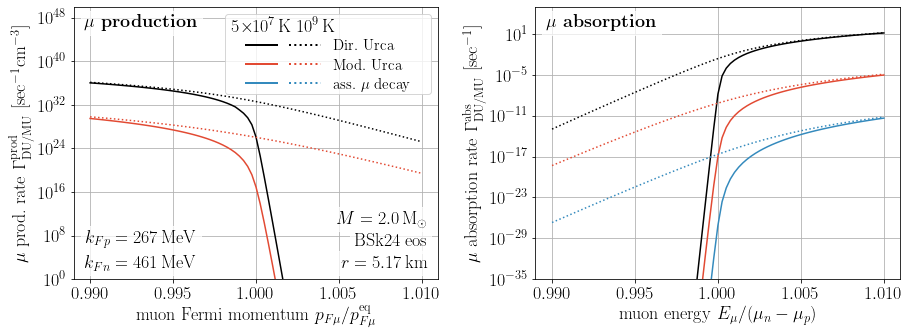

In [15]:
T_table = np.array([5e7, 1e9]) * u.Kelvin
my_ls   = ['-',':','--']

TO_colors = ['black',u'#E24A33', u'#348ABD', u'#988ED5', u'#777777', u'#FBC15E', u'#8EBA42',  u'#FFB5B8']
fig, ax = plt.subplots(1,2, figsize=(13,5))
[ax1,ax2] = ax

x_table = np.linspace(0.99, 1.01, 81)
ax1.set_prop_cycle(color=TO_colors)
for j, T in enumerate(T_table):
    ax1.plot(x_table, [Gamma_prod_DU(T, m_p_eff, m_n_eff, kFp, kFn, kFe, x*kFmu)*u.sec*u.cm**3 for x in x_table],
             color=TO_colors[0], ls=my_ls[j])
    ax1.plot(x_table, [Gamma_prod_MU(T, m_p_eff, m_n_eff, kFp, kFn, kFe, x*kFmu)*u.sec*u.cm**3 for x in x_table],
             color=TO_colors[1], ls=my_ls[j])
#ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(1,1e50)
ax1.set_xlabel(r'muon Fermi momentum $p_{F\mu} / p_{F\mu}^\text{eq}$')
ax1.set_ylabel(r'$\mu$ prod.\ rate $\Gamma^\text{prod}_\text{DU/MU}$ [\si{sec^{-1} cm^{-3}}]')
ax1.annotate(f'\\begin{{align*}} k_{{Fp}} &= \\SI{{{kFp/u.MeV:.0f}}}{{MeV}} \\\\ k_{{Fn}} &= \\SI{{{kFn/u.MeV:.0f}}}{{MeV}} \\end{{align*}}',
             (0.03,0.03), xycoords='axes fraction', va='bottom', ha='left', backgroundcolor='#ffffffbb')
ax1.annotate(r'\bf $\mu$ production', (0.03,0.97), xycoords='axes fraction', va='top', ha='left', backgroundcolor='#ffffffbb')
ax1.annotate(f'$M = \SI{{{M}}}{{M_\odot}}$', (0.97,0.19), xycoords='axes fraction', va='bottom', ha='right', backgroundcolor='#ffffffbb')
ax1.annotate(f'{eos} eos',                   (0.97,0.11), xycoords='axes fraction', va='bottom', ha='right', backgroundcolor='#ffffffbb')
ax1.annotate(f'$r = \SI{{{r/u.km}}}{{km}}$', (0.97,0.03), xycoords='axes fraction', va='bottom', ha='right', backgroundcolor='#ffffffbb')
ax1.grid()

ax2.set_prop_cycle(color=TO_colors)
for j, T in enumerate(T_table):
    ax2.plot(x_table, [Gamma_abs_DU(x*mu_mu, T, m_p_eff, m_n_eff, kFp, kFn, kFe, kFmu)*u.sec for x in x_table],
             color=TO_colors[0], ls=my_ls[j])
    ax2.plot(x_table, [Gamma_abs_MU(x*mu_mu, T, m_p_eff, m_n_eff, kFp, kFn, kFe, kFmu)*u.sec for x in x_table],
             color=TO_colors[1], ls=my_ls[j])
    ax2.plot(x_table, [Gamma_amd(x*mu_mu, T, m_p_eff, kFe)*u.sec for x in x_table],
             color=TO_colors[2], ls=my_ls[j])
#ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim(1e-35,1e5)
ax2.set_xlabel(r'muon energy $E_\mu/(\mu_n - \mu_p)$')
ax2.set_ylabel(r'$\mu$ absorption rate $\Gamma^\text{abs}_\text{DU/MU}$ [\si{sec^{-1}]')
ax2.annotate(r'\bf $\mu$ absorption', (0.03,0.97), xycoords='axes fraction', va='top', ha='left', backgroundcolor='#ffffffbb')
ax2.grid()

my_legend_lines = [ tuple([ lines.Line2D([0], [0], color=TO_colors[k], ls=my_ls[j], lw=2)
                          for j in range(len(T_table)) ]) for k in range(3) ]
leg = ax1.legend(my_legend_lines, ['Dir.\ Urca','Mod.\ Urca','ass.\ $\mu$ decay'],
                 loc='upper right', handlelength=5, labelspacing=0.4, borderpad=.2, fontsize='small',
                 handler_map={tuple: mpl.legend_handler.HandlerTuple(ndivide=None,pad=.8)},
                 title=r'$5\!\times\!\!10^7$\,K\ $10^9$\,K')
leg.get_title().set_position((-45,0))
#print(leg._legend_box)
leg._legend_box.set_width(200)

plt.tight_layout()
plt.show()

#### Pizza Slice Plots

In [15]:
#T                   = 1e7 * u.Kelvin
T                   = 5e7 * u.Kelvin
eos                 = 'BSk24'
M                   = '2.0'

star_file           = base_dir + f'/packages/nscool/results/scan-{eos}/run-{M}/Star_Try.dat'
star_data           = pd.read_csv(star_file, skiprows=4, delim_whitespace=True, index_col=0)
star_data['rad']   *= u.meter
star_data['rho']   *= u.grams/u.cm**3
star_data[['kf(e)','kf(mu)','kf(p)','kf(n)']] /= u.fm
star_data['kf(mu)'] = np.sqrt(np.fmax(0, star_data['kf(e)']**2 + u.m_e**2 - u.m_mu**2))
                          # impose exact beta equilibrium; NSCool output has tiny numerical inaccuracies
                          #   but the Urca rates are very sensitive to these
star_data['mstn']  *= u.m_n
star_data['mstp']  *= u.m_p
R_NS                = np.amax(star_data['rad'][star_data['kf(n)']>0])  # neutron star radius
R_CC                = star_data['rad'][np.loadtxt(star_file, max_rows=1, dtype=int)[2]] # radius of core-crust boundary
x_table = np.concatenate((1-np.logspace(-1,-3,21)[:-1], np.linspace(0.999,1.001,21), 1+np.logspace(-3,-1,21)[1:]))

Gamma_prod_MU_table    = np.array([[ Gamma_prod_MU(T, s['mstp'], s['mstn'], s['kf(p)'], s['kf(n)'], s['kf(e)'], x*s['kf(mu)'])
                                      for x in x_table ] for j, s in star_data.iterrows() if s['kf(n)']>0 ])
Gamma_prod_MU_eq_table = np.array([  Gamma_prod_MU(T, s['mstp'], s['mstn'], s['kf(p)'], s['kf(n)'], s['kf(e)'], s['kf(mu)'])
                                      for j, s in star_data.iterrows() if s['kf(n)']>0 ])
Gamma_prod_DU_table    = np.array([[ Gamma_prod_DU(T, s['mstp'], s['mstn'], s['kf(p)'], s['kf(n)'], s['kf(e)'], x*s['kf(mu)'])
                                      for x in x_table ] for j, s in star_data.iterrows() if s['kf(n)']>0 ])
Gamma_prod_DU_eq_table = np.array([  Gamma_prod_DU(T, s['mstp'], s['mstn'], s['kf(p)'], s['kf(n)'], s['kf(e)'], s['kf(mu)'])
                                      for j, s in star_data.iterrows() if s['kf(n)']>0 ])

Gamma_abs_MU_table     = np.array([[ Gamma_abs_MU(max(u.m_mu, x*np.sqrt(s['kf(mu)']**2 + u.m_mu**2)),
                                                  T, s['mstp'], s['mstn'], s['kf(p)'], s['kf(n)'], s['kf(e)'], s['kf(mu)'])
                                      for x in x_table ] for j, s in star_data.iterrows() if s['kf(n)']>0 ])
Gamma_abs_MU_eq_table  = np.array([  Gamma_abs_MU(np.sqrt(s['kf(mu)']**2 + u.m_mu**2),
                                                  T, s['mstp'], s['mstn'], s['kf(p)'], s['kf(n)'], s['kf(e)'], s['kf(mu)'])
                                      for j, s in star_data.iterrows() if s['kf(n)']>0 ])
Gamma_abs_DU_table     = np.array([[ Gamma_abs_DU(max(u.m_mu, x*np.sqrt(s['kf(mu)']**2 + u.m_mu**2)),
                                                  T, s['mstp'], s['mstn'], s['kf(p)'], s['kf(n)'], s['kf(e)'], s['kf(mu)'])
                                      for x in x_table ] for j, s in star_data.iterrows() if s['kf(n)']>0 ])
Gamma_abs_DU_eq_table  = np.array([  Gamma_abs_DU(np.sqrt(s['kf(mu)']**2 + u.m_mu**2),
                                                  T, s['mstp'], s['mstn'], s['kf(p)'], s['kf(n)'], s['kf(e)'], s['kf(mu)'])
                                      for j, s in star_data.iterrows() if s['kf(n)']>0 ])
Gamma_amd_table        = np.array([[ Gamma_amd(max(u.m_mu, x*np.sqrt(s['kf(mu)']**2 + u.m_mu**2)), T, s['mstp'],
                                               s['kf(p)'], s['kf(n)'], s['kf(e)'], s['kf(mu)'])
                                      for x in x_table ] for j, s in star_data.iterrows() if s['kf(n)']>0 ])
Gamma_amd_eq_table     = np.array([  Gamma_amd(np.sqrt(s['kf(mu)']**2 + u.m_mu**2), T, s['mstp'],
                                               s['kf(p)'], s['kf(n)'], s['kf(e)'], s['kf(mu)'])
                                      for j, s in star_data.iterrows() if s['kf(n)']>0 ])


<ipython-input-16-f1937bce6a61>:48: RuntimeWarning: divide by zero encountered in log10
  np.clip(np.log10(Gamma_table[::10]/Gamma_units), *Gamma_range), edgecolors='none',


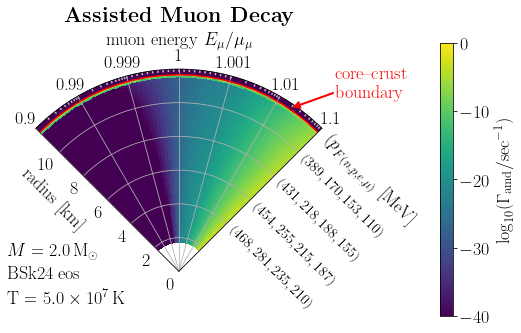

In [16]:
# choose process to plot
process = "amd"

if process == "prod-MU":
    Gamma_table    = Gamma_prod_MU_table
    plot_title     = 'Modified Urca Production'
    colorbar_label = r'$\log_{10}(\Gamma_\text{MU}^\text{prod} / \si{sec^{-1}\,cm^{-3}})$'
    output_file    = 'Gamma-MU-prod.pdf'
    Gamma_units    = 1/u.sec/u.cm**3
    Gamma_range    = (0, 40)
elif process == "prod-DU":
    Gamma_table    = Gamma_prod_DU_table
    plot_title     = 'Direct Urca Production'
    colorbar_label = r'$\log_{10}(\Gamma_\text{DU}^\text{prod} / \si{sec^{-1}\,cm^{-3}})$'
    output_file    = 'Gamma-DU-prod.pdf'
    Gamma_units    = 1/u.sec/u.cm**3
    Gamma_range    = (0, 40)
elif process == "abs-MU":
    Gamma_table    = Gamma_abs_MU_table
    plot_title     = 'Modified Urca Absorption'
    colorbar_label = r'$\log_{10}(\Gamma_\text{MU}^\text{abs} / \si{sec^{-1}})$'
    output_file    = 'Gamma-MU-abs.pdf'
    Gamma_units    = 1/u.sec
    Gamma_range    = (-40, 0)
elif process == "abs-DU":
    Gamma_table    = Gamma_abs_DU_table
    plot_title     = 'Direct Urca Absorption'
    colorbar_label = r'$\log_{10}(\Gamma_\text{DU}^\text{abs} / \si{sec^{-1}})$'
    output_file    = 'Gamma-DU-abs.pdf'
    Gamma_units    = 1/u.sec
    Gamma_range    = (-40, 0)
elif process == "amd":
    Gamma_table    = Gamma_amd_table
    plot_title     = 'Assisted Muon Decay'
    colorbar_label = r'$\log_{10}(\Gamma_\text{amd} / \si{sec^{-1}})$'
    output_file    = 'Gamma-amd.pdf'
    Gamma_units    = 1/u.sec
    Gamma_range    = (-40, 0)
else:
    raise ValueError(f'Process not implemented yet: {process}')

# plot color mesh
fig, ax = plt.subplots(figsize=(8,7), subplot_kw={'projection': 'polar'})
ax.set_prop_cycle(color=TO_colors)
x2_table  = np.linspace(-3,3,len(x_table))    # positions of labels on plot (as opposed to physical x)
ax.grid(False)    # Python asks me to first set grid to False, then draw the colormesh, then set it to True again
pp = ax.pcolormesh(x2_table/3*np.pi/4, star_data['rad'][star_data['kf(n)']>0][::10]/u.km,
                   np.clip(np.log10(Gamma_table[::10]/Gamma_units), *Gamma_range), edgecolors='none',
                   vmin=Gamma_range[0], vmax=Gamma_range[1])

# axes
ax.set_rlim(0, R_NS/u.km)
ax.set_thetalim(-np.pi/4, np.pi/4)
ax.set_theta_zero_location(loc='N')
ax.set_theta_direction(-1)
ax.set_xticks(np.linspace(-3,3,7)/3*np.pi/4, [0.9,0.99,0.999,1,1.001,1.01,1.1], minor=False)
xx1 = np.log10(np.linspace(1,9,9))
xx2 = np.linspace(-1,1,21)
#ax.set_xticks(np.concatenate((-3+xx1,-2+xx1,xx2,1+xx1,2+xx1))/3*np.pi/4, minor=True, direction='out')
                         # this doesn't work on my laptop, no idea why. The result still looks OK though
#ax.tick_params(axis='x', which='minor', color='white', zorder=5, length=5, direction='out')
ax.grid(True)
#ax.grid(visible=True, which='minor', axis='x')
ax.annotate(r'radius [km]', (0.06,0.4), rotation=-45, xycoords='axes fraction', ha='center', va='center')
if process[:3] == 'abs' or process[:3] == 'amd':
    ax.annotate(r'muon energy $E_\mu/\mu_\mu$',
                (0.5,0.92), xycoords='axes fraction', ha='center', va='bottom')
elif process[:4] == 'prod':
    ax.annotate(r'deviation from equilibrium $p_{F\mu}/p_{F\mu}^\text{eq}$',
                (0.5,0.92), xycoords='axes fraction', ha='center', va='bottom')
else:
    raise ValueError(f"don't know how to annotate plot for process {process}")

# minor tick marks
tt = np.concatenate((-3+xx1,-2+xx1,xx2,1+xx1,2+xx1))/3*np.pi/4
for t in tt:
    ax.plot([t,t], [R_NS/u.km,0.99*R_NS/u.km], color='#bbbbbb')

# annotate Fermi momenta
ax.annotate(f'$(p_{{F(n,p,e,\mu)}}$ [MeV]',
            (0.25*np.pi,11.8), rotation=-45, ha='left', va='top', fontsize=18)
for rr in np.array([4,6,8,10])*u.km:
    jj = np.argmin((star_data['rad'] - rr)**2)
    ax.annotate(f'$({star_data["kf(n)"][jj]/u.MeV:.0f}, {star_data["kf(p)"][jj]/u.MeV:.0f}, {star_data["kf(e)"][jj]/u.MeV:.0f}, {star_data["kf(mu)"][jj]/u.MeV:.0f})$',
                (0.25*np.pi,rr/u.km), rotation=-45, ha='left', va='top', fontsize=14)

# indicate core-crust boundary
ax.plot(np.linspace(-np.pi/4,np.pi/4,21), np.full(21,R_CC/u.km), color='red')
ax.annotate(r'\flushleft core--crust\\[0.2cm]boundary', (1.3,0.8), xycoords='axes fraction', color='red',
            ha='right', va='center')
ax.annotate('', (0.9,0.72), xytext=(1.04,0.77), color='red', xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(facecolor='red', edgecolor='red', width=1, headwidth=7, headlength=7))

# indicate muonsphere
# R_musphere = np.amax(star_data['rad'][star_data['kf(mu)']>0])
# ax.plot(np.linspace(-np.pi/4,np.pi/4,21), np.full(21,R_musphere/u.km), color='orange')

# other annotations
ax.annotate(f'$M = \SI{{{M}}}{{M_\odot}}$',      (-0.1,0.19), xycoords='axes fraction', ha='left', va='bottom')
ax.annotate(f'{eos} eos',                        (-0.1,0.11), xycoords='axes fraction', ha='left', va='bottom')
ax.annotate(f'T = \SI{{{T/u.Kelvin:.1e}}}{{K}}', (-0.1,0.03), xycoords='axes fraction', ha='left', va='bottom')
ax.set_title(r'\bf {:s}'.format(plot_title))

# color bar legend
plt.colorbar(pp, ax=ax, shrink=0.6, anchor=(2.5,.45), label=colorbar_label)
# plt.colorbar(pp, ax=ax, shrink=0.6, anchor=(2.5,.45),
#              label=r'$\log_{10}(\Gamma_{MU}^\text{prod} / \Gamma_{MU}^\text{prod,eq})$')

plt.tight_layout()
plt.savefig('fig/'+output_file)
plt.show()

#### Comparison of Production, Absorption, and Diffusion Rates

<ipython-input-13-389b2c8b4eed>:52: RuntimeWarning: invalid value encountered in divide
  tau_e    = kappa_e  * 3*kfe  / (np.pi**2 * T * n_e)
<ipython-input-13-389b2c8b4eed>:53: RuntimeWarning: invalid value encountered in divide
  tau_mu   = kappa_mu * 3*mumu / (np.pi**2 * T * n_mu)
/Users/jkopp/Dropbox (Personal)/ns-muons/jk/muon_propagator.py:444: RuntimeWarning: invalid value encountered in scalar divide
  A       = (mu_e - E_mu) / T
/Users/jkopp/Dropbox (Personal)/ns-muons/jk/muon_propagator.py:505: RuntimeWarning: divide by zero encountered in scalar divide
  / (np.pi**5/T**8 * u.m_mu**8) \
/Users/jkopp/Dropbox (Personal)/ns-muons/jk/muon_propagator.py:506: RuntimeWarning: invalid value encountered in scalar divide
  * I_amd((mu_e - E_mu)/T))
/Users/jkopp/Dropbox (Personal)/ns-muons/jk/muon_propagator.py:571: RuntimeWarning: divide by zero encountered in scalar divide
  x = np.clip((pe - mu)/T, -100., 100.)


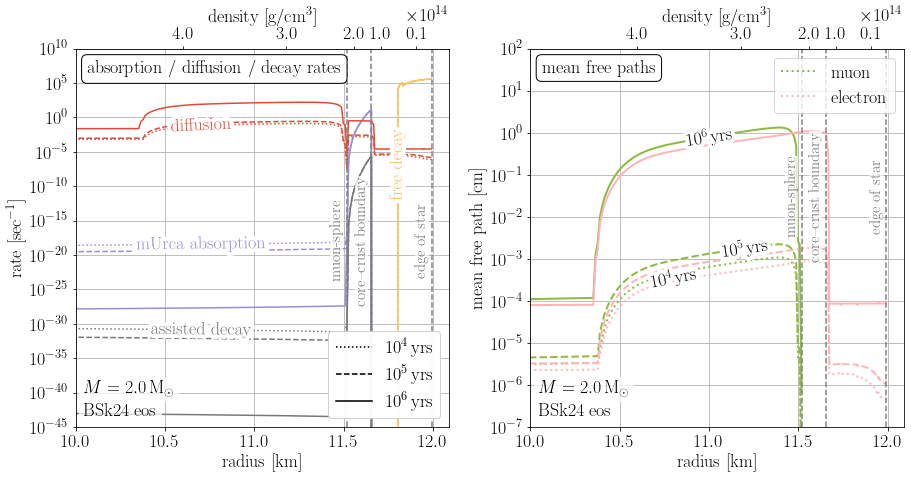

In [13]:
import labellines as ll
eos                 = 'BSk24'
M                   = '2.0'

# load stellar structure data
nscool_dir          = base_dir + f'/packages/nscool/results/scan-{eos}/run-{M}/'
star_file           = nscool_dir + '/Star_Try.dat'
star_data           = pd.read_csv(star_file, skiprows=4, delim_whitespace=True, index_col=0)
star_data['rad']   *= u.meter
star_data['rho']   *= u.grams/u.cm**3
star_data[['kf(e)','kf(mu)','kf(p)','kf(n)']] /= u.fm
star_data['kf(mu)'] = np.sqrt(np.fmax(0, star_data['kf(e)']**2 + u.m_e**2 - u.m_mu**2))
                          # impose exact beta equilibrium; NSCool output has tiny numerical inaccuracies
                          #   but the Urca rates are very sensitive to these
star_data['mstn']  *= u.m_n
star_data['mstp']  *= u.m_p
R_NS                = np.amax(star_data['rad'][star_data['kf(n)']>0])  # neutron star radius
R_CC                = star_data['rad'][np.loadtxt(star_file, max_rows=1, dtype=int)[2]] # radius of core-crust boundary

# compute muon and electron mfp as well as diffusion velocity as a function of t and r
# (code copied from muon_propagator.py on 2021-01-31)
fig    = plt.figure(figsize=(13,7))
ax1    = fig.add_subplot(121)
ax2    = fig.add_subplot(122)
my_ls  = [':', '--', '-']
ir     = np.where(star_data['kf(n)']>0)[0]
mp     = muon_propagator(nscool_dir, 'mu-width-table.dat')
r      = star_data['rad']
t_list = np.array([1e4,1e5,1e6]) * u.yrs
mfp_e  = np.zeros((len(t_list), len(r))) # electron mean free path
mfp_mu = np.zeros((len(t_list), len(r))) # muon mean free path
v_diff = np.zeros((len(t_list), len(r))) # diffusion speed
dr     = 100 * u.m

kfmu   = mp.kfmu_interp(r)               # muon Fermi momentum
kfe    = mp.kfe_interp(r)                # electron Fermi momentum
mumu   = np.sqrt(u.m_mu**2 + kfmu**2)    # muon chemical potential
mue    = np.sqrt(u.m_e**2 + kfe**2)      # electron chemical potential
n_mu   = kfmu**3 / (3*np.pi**2)          # muon number density
                            # https://en.wikipedia.org/wiki/Fermi_energy
n_e    = kfe**3 / (3*np.pi**2)           # electron number density
for j, t in enumerate(t_list):
    t_r      = np.array([np.full_like(r, t), r]).T
    T        = mp.temp_data_interp2d[j_T](t_r) # temperature
    kappa_e  = mp.temp_data_interp2d[j_lambdaE](t_r)
    kappa_mu = mp.temp_data_interp2d[j_lambdaMu](t_r)
    v_th_mu  = np.sqrt(8*T/(np.pi*u.m_mu))  # thermal velocity
                               # (Maxwell-Boltzmann, no chemical potential)
    vfmu     = kfmu / mumu               # muon Fermi velocity
    vfe      = 1

    tau_e    = kappa_e  * 3*kfe  / (np.pi**2 * T * n_e)
    tau_mu   = kappa_mu * 3*mumu / (np.pi**2 * T * n_mu)
                    # relaxation time, https://arxiv.org/abs/0705.1963, eq. (4)
                    # this expression can be understood as follows:
                    #   random walk travel distance: dx = \lambda \sqrt{N}
                    #     (\lambda=mfp, N=# of interactions)
                    #   -> dx = \lambda \sqrt{dt / \tau} = v \sqrt{\tau*dt}
                    #   Heat flux: T*\phi = T*n*dx/dt
                    #                     = T * n * v^2 * \tau * dt / (dx*dt)
                    #                     = T * n * T/m * \tau / dx
                    #   from the definition T*\phi = \kappa * dT/dx
                    #   we obtain \kappa = T * n * \tau / m
    mfp_mu   = np.where(kfmu>0, tau_mu*vfmu, tau_e*vfe)
                    # muon mean free path; use mfp for e- as a fallback

    t_coll   = np.where(kfmu>0, tau_mu, tau_e/v_th_mu)     # collision time, e- as fallback
    t_diff   = t_coll * (dr/mfp_mu)**2             # time needed to diffuse over distance dr on average
    
    # plot rates
    ax1.plot(star_data['rad'][ir]/u.km, [ Gamma_abs_MU(np.sqrt(s['kf(mu)']**2 + u.m_mu**2), T[k], s['mstp'] if s['mstp']>0 else u.m_p,
                                                       s['mstn'], s['kf(p)'], s['kf(n)'], s['kf(e)'], s['kf(mu)'])*u.sec
                                                       for k, s in star_data.iloc[ir].iterrows() ], c=TO_colors[3], ls=my_ls[j], label=r'mUrca absorption')
    ax1.plot(star_data['rad'][ir]/u.km, [ Gamma_amd(np.sqrt(s['kf(mu)']**2 + u.m_mu**2), T[k], s['mstp'] if s['mstp']>0 else u.m_p,
                                                    s['kf(p)'], s['kf(n)'], s['kf(e)'], s['kf(mu)'])*u.sec
                                                    for k, s in star_data.iloc[ir].iterrows() ], c=TO_colors[4], ls=my_ls[j], label=r'assisted decay')
    ax1.plot(star_data['rad'][ir]/u.km, 1/t_diff[ir] * u.sec, color=TO_colors[1], ls=my_ls[j], label='diffusion')
    ax1.plot(star_data['rad'][ir]/u.km, [ mu_width(p_mu=0, mu=mue[k], T=T[k]) * u.sec for k, s in star_data.iloc[ir].iterrows() ], color=TO_colors[5], ls=my_ls[j], label='free decay')

    # plot mean free paths
    ax2.plot(star_data['rad'][ir]/u.km, (tau_mu*vfmu)[ir]/u.cm, c=TO_colors[6], ls=my_ls[j], lw=2, label='muon')
    ax2.plot(star_data['rad'][ir]/u.km, (tau_e*vfe)[ir]/u.cm,   c=TO_colors[7], ls=my_ls[j], lw=2, label='electron')

# annotate rate plot
ax1.axvline(R_NS/u.km, c='gray', ls='--')
ax1.axvline(mp.r_CC_boundary/u.km, c='gray', ls='--')
ax1.axvline(min(star_data['rad'][star_data['kf(mu)']<=0])/u.km, c='gray', ls='--')
ax1.annotate('edge of star',         (R_NS/u.km-0.02, 1e-18),
             ha='right', va='center', rotation=90, color='gray', fontsize='small', bbox=dict(boxstyle='square,pad=0', fc='#ffffffbb', ec='none'))
ax1.annotate('core--crust boundary', (mp.r_CC_boundary/u.km-0.02, 1e-18),
             ha='right', va='center', rotation=90, color='gray', fontsize='small', bbox=dict(boxstyle='square,pad=0', fc='#ffffffbb', ec='none'))
ax1.annotate('muon-sphere',          (min(star_data['rad'][star_data['kf(mu)']<=0])/u.km-0.02, 1e-18),
             ha='right', va='center', rotation=90, color='gray', fontsize='small', bbox=dict(boxstyle='square,pad=0', fc='#ffffffbb', ec='none'))
ax1.set_xlabel(r'radius [km]')
ax1.set_ylabel(r'rate [sec$^{-1}$]')
ax1.set_yscale('log')
ax1.set_xlim(10,R_NS/u.km+0.1)
ax1.set_ylim(1e-45,1e10)
ax1.yaxis.set_major_locator(mpl.ticker.LogLocator(numticks=12))
ax1.annotate(f'$M = \SI{{{M}}}{{M_\odot}}$', (0.02,0.08), xycoords='axes fraction', ha='left', va='bottom', backgroundcolor='#ffffffbb')
ax1.annotate(f'{eos} eos',                   (0.02,0.02), xycoords='axes fraction', ha='left', va='bottom', backgroundcolor='#ffffffbb')
ll.labelLine(ax1.get_lines()[0], x=10.7, align=True, zorder=2.5)
ll.labelLine(ax1.get_lines()[1], x=10.7, align=True, zorder=2.5)
ll.labelLine(ax1.get_lines()[2], x=10.7, align=True, zorder=2.5)
ll.labelLine(ax1.get_lines()[3], x=11.8, align=True, yoffset=-10, yoffset_logspace=True, zorder=2.5)
handles1 = []
labels1  = []
for j, t in enumerate(t_list):
    handles1.append( mpl.lines.Line2D(xdata=[0,1], ydata=[0,0], color='k', ls=my_ls[j]) )
    labels1.append( r'\SI{' + f'{t/u.yrs:.1e}'[3:] + r'}{yrs}' )
legend1 = ax1.legend(handles1, labels1, loc='lower right', facecolor='#ffffff77')
ax1.add_artist(legend1)                    
ax1.annotate('absorption / diffusion / decay rates', (0.03,0.97), xycoords='axes fraction',
             ha='left', va='top', bbox=dict(boxstyle='round', fc='#ffffffdd', ec='black'))

# add secdonary x axis showing the density at each radius
sec_ax1 = ax1.secondary_xaxis('top', functions=(interp.interp1d(star_data['rad']/u.km, star_data['rho']/(u.grams/u.cm**3), kind='cubic', bounds_error=False, fill_value='extrapolate'),
                                                interp.interp1d(star_data['rho']/(u.grams/u.cm**3), star_data['rad']/u.km, kind='cubic', bounds_error=False, fill_value='extrapolate')))
sec_ax1.set_xlabel(r'density [g/cm$^3$]')
sec_ax1.set_xticks(np.array([0.1,1,2,3,4,5,6,7])*1e14)
ax1.grid()

# annotate mfp plot
ax2.axvline(R_NS/u.km, c='gray', ls='--')
ax2.axvline(mp.r_CC_boundary/u.km, c='gray', ls='--')
ax2.axvline(min(star_data['rad'][star_data['kf(mu)']<=0])/u.km, c='gray', ls='--')
ax2.annotate('edge of star',         (R_NS/u.km-0.02, 3e-2),
             ha='right', va='center', rotation=90, color='gray', fontsize='small', bbox=dict(boxstyle='square,pad=0', fc='#ffffffbb', ec='none'))
ax2.annotate('core--crust boundary', (mp.r_CC_boundary/u.km-0.02, 3e-2),
             ha='right', va='center', rotation=90, color='gray', fontsize='small', bbox=dict(boxstyle='square,pad=0', fc='#ffffffbb', ec='none'))
ax2.annotate('muon-sphere',          (min(star_data['rad'][star_data['kf(mu)']<=0])/u.km-0.02, 3e-2),
             ha='right', va='center', rotation=90, color='gray', fontsize='small', bbox=dict(boxstyle='square,pad=0', fc='#ffffffbb', ec='none'))
ax2.set_yscale('log')
ax2.set_xlabel(r'radius [km]')
ax2.set_ylabel(r'mean free path [cm]')
ax2.set_xlim(10,R_NS/u.km+0.1)
ax2.set_ylim(1e-7,1e2)
ax2.yaxis.set_major_locator(mpl.ticker.LogLocator(numticks=20))
ax2.annotate(f'$M = \SI{{{M}}}{{M_\odot}}$', (0.02,0.08), xycoords='axes fraction', ha='left', va='bottom', backgroundcolor='#ffffffbb')
ax2.annotate(f'{eos} eos',                   (0.02,0.02), xycoords='axes fraction', ha='left', va='bottom', backgroundcolor='#ffffffbb')
ax2.grid()
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[:2], labels[:2], loc='upper right')
ll.labelLine(ax2.get_lines()[0], x=10.8, yoffset=-0.1, yoffset_logspace=True, align=True, zorder=2.5, color='k',
             label=r'\SI{' + f'{t_list[0]/u.yrs:.1e}'[3:] + r'}{yrs}')
ll.labelLine(ax2.get_lines()[2], x=11.2, yoffset=0.0, yoffset_logspace=True, align=True, zorder=2.5, color='k',
             label=r'\SI{' + f'{t_list[1]/u.yrs:.1e}'[3:] + r'}{yrs}')
ll.labelLine(ax2.get_lines()[4], x=11.0, yoffset=0.0, yoffset_logspace=True, align=True, zorder=2.5, color='k',
             label=r'\SI{' + f'{t_list[2]/u.yrs:.1e}'[3:] + r'}{yrs}')
ax2.annotate('mean free paths', (0.03,0.97), xycoords='axes fraction',
             ha='left', va='top', bbox=dict(boxstyle='round', fc='#ffffffdd', ec='black'))

sec_ax2 = ax2.secondary_xaxis('top', functions=(interp.interp1d(star_data['rad']/u.km, star_data['rho']/(u.grams/u.cm**3), kind='cubic', bounds_error=False, fill_value='extrapolate'),
                                                interp.interp1d(star_data['rho']/(u.grams/u.cm**3), star_data['rad']/u.km, kind='cubic', bounds_error=False, fill_value='extrapolate')))
sec_ax2.set_xlabel(r'density [g/cm$^3$]')
sec_ax2.set_xticks(np.array([0.1,1,2,3,4,5,6,7])*1e14)

plt.tight_layout()
plt.savefig('fig/rates-mfps.pdf')
plt.show()

#### Radius-Integrated Rates

In [18]:
x_table = np.concatenate((1-np.logspace(-1,-3,21)[:-1], np.linspace(0.999,1.001,21), 1+np.logspace(-3,-1,21)[1:]))
Gamma_prod_MU_table_2d = {}
Gamma_prod_MU_table    = {}
Gamma_prod_DU_table_2d = {}
Gamma_prod_DU_table    = {}
Gamma_abs_MU_table_2d  = {}
Gamma_abs_MU_table     = {}
Gamma_abs_DU_table_2d  = {}
Gamma_abs_DU_table     = {}
Gamma_amd_table_2d     = {}
Gamma_amd_table        = {}
eos_M_t_table          = [('BSk24','2.0',1e3*u.yrs), ('BSk24','2.0',1e6*u.yrs)]
#eos_M_t_table          = [('cat','2.0',1e3*u.yrs), ('cat','2.0',1e6*u.yrs)] # FIXME FIXME

for eos, M, t in eos_M_t_table:
    nscool_dir = base_dir + f'/packages/nscool/results/scan-{eos}/run-{M}/'
    mp = muon_propagator(nscool_dir, mu_width_file='mu-width-table.dat')
    
#    ii = (mp.star_data[:,k_r] > 0) & (mp.star_data[:,k_kfn] > 0) & (np.arange(len(star_data)) % 3 == 0)
#             # omit r=0 bin - temperature is undefined there
    ii = (mp.star_data[:,k_r] > 0) & (mp.star_data[:,k_r] < 10*u.km) & (mp.star_data[:,k_kfn] > 0) & (np.arange(len(mp.star_data)) % 3 == 0)
             # omit r=0 bin - temperature is undefined there # FIXME FIXME FIXME
    Gamma_prod_MU_table_2d[eos,M,t] = np.array([[ Gamma_prod_MU(mp.temp_data_interp2d[j_T]((t,s[k_r])),
                                                                s[k_mstp], s[k_mstn], s[k_kfp], s[k_kfn], s[k_kfe], x*s[k_kfmu])
                                                      for x in x_table ] for s in mp.star_data[ii] ])
    Gamma_prod_MU_table[eos,M,t]    = np.array([ integ.trapz(x = mp.star_data[ii,k_r],
                                                          y = 4*np.pi * mp.star_data[ii,k_r]**2 * G)
                                                      for G in Gamma_prod_MU_table_2d[eos,M,t].T ])
    Gamma_prod_DU_table_2d[eos,M,t] = np.array([[ Gamma_prod_DU(mp.temp_data_interp2d[j_T]((t,s[k_r])),
                                                                s[k_mstp], s[k_mstn], s[k_kfp], s[k_kfn], s[k_kfe], x*s[k_kfmu])
                                                      for x in x_table ] for s in mp.star_data[ii] ])
    Gamma_prod_DU_table[eos,M,t]    = np.array([ integ.trapz(x = mp.star_data[ii,k_r],
                                                          y = 4*np.pi * mp.star_data[ii,k_r]**2 * G)
                                                      for G in Gamma_prod_DU_table_2d[eos,M,t].T ])
    
    Gamma_abs_DU_table_2d[eos,M,t] = np.array([[ Gamma_abs_DU_integ(mp.temp_data_interp2d[j_T]((t,s[k_r])),
                                             s[k_mstp], s[k_mstn], s[k_kfp], s[k_kfn], s[k_kfe], x*s[k_kfmu])
                                                  for x in x_table ] for s in mp.star_data[ii] ])
    Gamma_abs_DU_table[eos,M,t]    = np.array([ integ.trapz(x = mp.star_data[ii,k_r],
                                                          y = 4*np.pi * mp.star_data[ii,k_r]**2 * G)
                                                      for G in Gamma_abs_DU_table_2d[eos,M,t].T ])
    Gamma_abs_MU_table_2d[eos,M,t] = np.array([[ Gamma_abs_MU_integ(mp.temp_data_interp2d[j_T]((t,s[k_r])),
                                             s[k_mstp], s[k_mstn], s[k_kfp], s[k_kfn], s[k_kfe], x*s[k_kfmu])
                                                  for x in x_table ] for s in mp.star_data[ii] ])
    Gamma_abs_MU_table[eos,M,t]    = np.array([ integ.trapz(x = mp.star_data[ii,k_r],
                                                          y = 4*np.pi * mp.star_data[ii,k_r]**2 * G)
                                                      for G in Gamma_abs_MU_table_2d[eos,M,t].T ])
    
    Gamma_amd_table_2d[eos,M,t]    = np.array([[ Gamma_amd_integ(mp.temp_data_interp2d[j_T]((t,s[k_r])),
                                                                 s[k_mstp], s[k_kfp], s[k_kfn], s[k_kfe], x*s[k_kfmu])
                                                      for x in x_table ] for s in mp.star_data[ii] ])
    Gamma_amd_table[eos,M,t]       = np.array([ integ.trapz(x = mp.star_data[ii,k_r],
                                                          y = 4*np.pi * mp.star_data[ii,k_r]**2 * G)
                                                      for G in Gamma_amd_table_2d[eos,M,t].T ])


In [19]:
N_mu     = {}
t_diff   = {}
t_diff_2 = {}
# eos_M_t_table = [('cat',  '1.8',1e5*u.yrs),
#                  ('BSk22','1.8',1e5*u.yrs),
#                  ('BSk24','1.8',1e5*u.yrs),
#                  ('BSk25','1.8',1e5*u.yrs),
#                  ('BSk26','1.8',1e5*u.yrs)]
for eos, M, t in eos_M_t_table:
    nscool_dir = base_dir + f'/packages/nscool/results/scan-{eos}/run-{M}/'
    mp         = muon_propagator(nscool_dir, mu_width_file='mu-width-table.dat')

    r          = mp.r_table
    t_r        = np.vstack(([t]*len(r),r)).T     # (t,r) points as argument to interpolating functions
    kfmu       = mp.kfmu_interp(r)               # muon Fermi momentum
    kfe        = mp.kfe_interp(r)                # electron Fermi momentum
    n_mu       = kfmu**3 / (3*np.pi**2)          # muon number density
                             # https://en.wikipedia.org/wiki/Fermi_energy
    n_e        = kfe**3 / (3*np.pi**2)           # electron number density
    T          = mp.temp_data_interp2d[j_T](t_r) # temperature
    v_th_mu    = np.sqrt(8*T/(np.pi*u.m_mu))     # thermal velocity
                             # (Maxwell-Boltzmann, no chemical potential)
    N_mu[eos,M,t] = integ.trapz(x=r, y=4*np.pi*r**2 * n_mu)
    
    # compute electron mean free path
    Efe        = np.sqrt(kfe**2 + u.m_e**2)      # electron Fermi energy
    gamma_e    = Efe / u.m_e                     # relativistic gamma factor
    vfe        = np.sqrt(np.fmax(0, 1 - 1/gamma_e**2)) # Fermi velocity
    kappa_e    = mp.temp_data_interp2d[j_lambdaE](t_r) # thermal conductivity
    tau_e      = kappa_e * 3*kfe/(np.pi**2 * T * n_e)
                             # relaxation time, https://arxiv.org/abs/0705.1963, eq. (4)
                             # this expression can be understood as follows:
                             #   random walk travel distance: dx = \lambda \sqrt{N}
                             #     (\lambda=mfp, N=# of interactions)
                             #   -> dx = \lambda \sqrt{dt / \tau} = v \sqrt{\tau*dt}
                             #   Heat flux: T*\phi = T*n*dx/dt
                             #                     = T * n * v^2 * \tau * dt / (dx*dt)
                             #                     = T * n * T/m * \tau / dx
                             #   from the definition T*\phi = \kappa * dT/dx
                             #   we obtain \kappa = T * n * \tau / m
    mfp_e      = tau_e * vfe                     # mean free path

    # compute muon mean free path
    Efmu       = np.sqrt(kfmu**2 + u.m_mu**2)
    gamma_mu   = Efmu / u.m_mu
    vfmu       = np.sqrt(np.fmax(0, 1 - 1/gamma_mu**2))
    kappa_mu   = mp.temp_data_interp2d[j_lambdaMu](t_r)
    tau_mu     = np.where(n_mu>0, kappa_mu * 3*kfmu/(np.pi**2 * T * n_mu), 0.)
    mfp_mu     = tau_mu * vfmu
    
    # compute muon diffusion coefficient
    dr         = 10 * u.m
    dn_mu_dr   = (mp.kfmu_interp(r+0.5*dr)**3 - mp.kfmu_interp(r-0.5*dr)**3) / (3*np.pi**2 * dr)
    D          = mfp_mu*vfmu
    
    # the solution to the diffusion equation (dn/dt = D \Delta n) for constant D is a Gaussian of the form
    # n(X,t) = exp(-(x^2+y^2+z^2)/(4 D t)) / (4 \pi k t)^{3/2} in 1D for the initial condition
    # n(X,0) = \delta^{(3)}(X) (check this by direct calculation; a reference is
    # https://www.math.ttu.edu/~gilliam/ttu/f08/m4354_f08/m4354_ch3_heat_ivp.pdf).
    # Here, we solve for \int_{R_{NS}}^\infty 4 \pi r^2 n(r, t) dr = 0.5, see urca.nb
    i_mu       = np.where(D==0.)[0][0]
    r_mu       = r[:i_mu]
#    D_avg      = integ.trapz(x=r_mu, y=4*np.pi*r_mu**2 * D[:i_mu]) / (4/3*np.pi*r_mu[-1]**3)
    D_avg      = np.median(D)
#     n_int      = lambda t: r_mu[-1] * np.exp(-r_mu[-1]**2/(4*D_avg*t)) / (np.sqrt(np.pi*D_avg*t)) \
#                          + sf.erfc(r_mu[-1]/(2*np.sqrt(D_avg*t)))  -  0.5
    n_int      = lambda t: mp.R_NS * np.exp(-mp.R_NS**2/(4*D_avg*t)) / (np.sqrt(np.pi*D_avg*t)) \
                         + sf.erfc(mp.R_NS/(2*np.sqrt(D_avg*t)))  -  0.5
    t_diff[eos,M,t] = opt.root_scalar(n_int, bracket=[1e-10*u.yrs, 1*u.yrs]).root
    
    # an alternative approach to computing the diffusion time scale, based on the diffusion velocity
    v_diff     = D * np.abs(dn_mu_dr) / n_mu
    ii         = (kappa_mu > 0)
    t_diff_2[eos,M,t] = integ.trapz(x=r[ii], y=1/v_diff[ii])

<ipython-input-19-7bb571eedaa1>:48: RuntimeWarning: invalid value encountered in divide
  tau_mu     = np.where(n_mu>0, kappa_mu * 3*kfmu/(np.pi**2 * T * n_mu), 0.)
<ipython-input-19-7bb571eedaa1>:72: RuntimeWarning: invalid value encountered in divide
  v_diff     = D * np.abs(dn_mu_dr) / n_mu


<ipython-input-20-6733259ec397>:111: RuntimeWarning: divide by zero encountered in power
  dEF_dn_e         = 0.5/EF_e_table  * (2/3)*(ne_table  * 3*np.pi**2)**(-1/3) * 3*np.pi**2  # d(E_{Fe})/dn_e
<ipython-input-20-6733259ec397>:112: RuntimeWarning: divide by zero encountered in power
  dEF_dn_mu        = 0.5/EF_mu_table * (2/3)*(nmu_table * 3*np.pi**2)**(-1/3) * 3*np.pi**2  # d(E_{Fmu})/dn_e
<ipython-input-20-6733259ec397>:113: RuntimeWarning: invalid value encountered in multiply
  dn_e_table       = np.sqrt((EF_e_table  - dEF_dn_e *ne_table*this_drho_tidal)**2  - u.m_e**2)**3/(3*np.pi**2)  - ne_table
<ipython-input-20-6733259ec397>:115: RuntimeWarning: invalid value encountered in multiply
  dn_mu_table      = np.sqrt((EF_mu_table - dEF_dn_mu*nmu_table*this_drho_tidal)**2 - u.m_mu**2)**3/(3*np.pi**2) - nmu_table


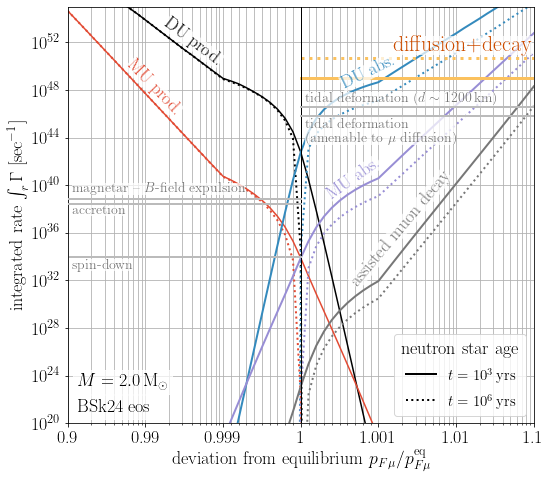

In [20]:
TO_colors = ['black',u'#E24A33', u'#348ABD', u'#988ED5', u'#777777', u'#FBC15E', u'#8EBA42',  u'#FFB5B8']
my_ls     = ['-', ':']
fig, ax   = plt.subplots(1,1,figsize=(8,7))
x2_table  = np.linspace(-3,3,len(x_table))    # positions of labels on plot (as opposed to physical x)
ax.plot(x2_table, Gamma_prod_DU_table[eos_M_t_table[0]]*u.sec, color=TO_colors[0], ls=my_ls[0], label='Direct Urca')
ax.plot(x2_table, Gamma_prod_DU_table[eos_M_t_table[1]]*u.sec, color=TO_colors[0], ls=my_ls[1], lw=2, label='Direct Urca')
ax.plot(x2_table, Gamma_prod_MU_table[eos_M_t_table[0]]*u.sec, color=TO_colors[1], ls=my_ls[0], label='Modified Urca')
ax.plot(x2_table, Gamma_prod_MU_table[eos_M_t_table[1]]*u.sec, color=TO_colors[1], ls=my_ls[1], lw=2, label='Modified Urca')

ax.plot(x2_table, Gamma_abs_DU_table[eos_M_t_table[0]]*u.sec, color=TO_colors[2], ls=my_ls[0], lw=2, label='Direct Urca')
ax.plot(x2_table, Gamma_abs_DU_table[eos_M_t_table[1]]*u.sec, color=TO_colors[2], ls=my_ls[1], lw=2, label='Direct Urca')
ax.plot(x2_table, Gamma_abs_MU_table[eos_M_t_table[0]]*u.sec, color=TO_colors[3], ls=my_ls[0], lw=2, label='Modified Urca')
ax.plot(x2_table, Gamma_abs_MU_table[eos_M_t_table[1]]*u.sec, color=TO_colors[3], ls=my_ls[1], lw=2, label='Modified Urca')

ax.plot(x2_table, Gamma_amd_table[   eos_M_t_table[0]]*u.sec, color=TO_colors[4], ls=my_ls[0], lw=2, label='Assisted muon decay')
ax.plot(x2_table, Gamma_amd_table[   eos_M_t_table[1]]*u.sec, color=TO_colors[4], ls=my_ls[1], lw=2, label='Assisted muon decay')

ax.axhline(N_mu[eos_M_t_table[0]]/t_diff[eos_M_t_table[0]]*u.sec, xmin=0.5, color=TO_colors[5], ls=my_ls[0], lw=3, label='Diffusion')
ax.axhline(N_mu[eos_M_t_table[1]]/t_diff[eos_M_t_table[1]]*u.sec, xmin=0.5, color=TO_colors[5], ls=my_ls[1], lw=3, label='Diffusion')

# configure axes
ax.set_yscale('log')
ax.set_xlabel(r'deviation from equilibrium $p_{F\mu}/p_{F\mu}^\text{eq}$')
ax.set_xticks(np.linspace(-3,3,7), [0.9,0.99,0.999,1,1.001,1.01,1.1], minor=False)
xx1 = np.log10(np.linspace(1,9,9))
xx2 = np.linspace(-1,1,21)
ax.set_xticks(np.concatenate((-3+xx1,-2+xx1,xx2,1+xx1,2+xx1)), minor=True)
ax.set_ylabel(r'integrated rate $\int_r \Gamma$ [\si{sec^{-1}}]')
ax.set_xlim(min(x2_table), max(x2_table))
ax.set_ylim(1e20,1e55)
ax.axvline(x2_table[np.where(x_table==1)], color='black', lw=1)
ax.grid()
ax.grid(visible=True, axis='x', which='minor')

# benchmarks
for eos, M, t in eos_M_t_table[:1]:
    nscool_dir      = base_dir + f'/packages/nscool/results/scan-{eos}/run-{M}/'
    mp              = muon_propagator(nscool_dir, mu_width_file='mu-width-table.dat')
    
    # total number of muons and electrons in the star
    N_mu_tot        = integ.trapz(x=mp.star_data[:,k_r], y=4*np.pi * mp.star_data[:,k_r]**2 
                                         * mp.eos_data_core_interp[l_Ymu](mp.star_data[:,k_rho])
                                         * mp.eos_data_core_interp[l_nbar](mp.star_data[:,k_rho]))
    N_e_tot         = integ.trapz(x=mp.star_data[:,k_r], y=4*np.pi * mp.star_data[:,k_r]**2 
                                         * mp.eos_data_core_interp[l_Ye](mp.star_data[:,k_rho])
                                         * mp.eos_data_core_interp[l_nbar](mp.star_data[:,k_rho]))
    
    # benchmark 1: spin-down
    this_Pdot       = 1e-15 * u.sec/u.sec   # typical value for spin-down rate from the standard P vs Pdot plot
    this_P          = 0.5 * u.sec           # typical value for pulsation frequency from the standard P vs Pdot plot
    this_f_Kepler   = np.sqrt(u.GN * mp.M_NS / mp.R_NS**3) / (2*np.pi) * (2/3)**(3/2) # Kepler frequency
    this_delta_rho  = 0.01 / (this_P * this_f_Kepler)**2  # relative change in core density during spin-down;
                                            # based on https://arxiv.org/abs/2206.12515, which shows that,
                                            # very roughly, the density increases by O(1%) between zero and the Kepler frequency
    this_delta_N_mu = N_mu_tot - 1/(1-this_delta_rho) * integ.trapz(x=mp.star_data[:,k_r], y=4*np.pi * mp.star_data[:,k_r]**2 
                                          * mp.eos_data_core_interp[l_Ymu]((1-this_delta_rho)*mp.star_data[:,k_rho]) 
                                          * mp.eos_data_core_interp[l_nbar]((1-this_delta_rho)*mp.star_data[:,k_rho]))
                                            # prefactor 1/(1-this_delta_rho) accounts for the overall expansion of the star
    Gamma_spindown  = this_delta_N_mu / (this_P/this_Pdot)
    ax.axhline(Gamma_spindown * u.sec, xmax=0.5, color='#bbbbbb', lw=2)
    ax.annotate(r'spin-down', (min(x2_table)+0.05, 0.7*Gamma_spindown*u.sec),
                ha='left', va='top', color='#777777', fontsize=14,
                bbox=dict(boxstyle='square,pad=0', fc='#ffffffbb', ec='none'))
    
    # benchmark 2: accretion
    # we assume here a 10% increase in the star's mass over 1 Gyr
    delta_t_acc     = 1e9 * u.yrs
    Gamma_acc       = 0.1*N_mu_tot/delta_t_acc
    ax.axhline(Gamma_acc * u.sec, xmax=0.5, color='#bbbbbb', lw=2, zorder=3.5)
    ax.annotate(r'accretion', (min(x2_table)+0.05, Gamma_acc*u.sec),
                ha='left', va='top', color='#777777', fontsize=14,
                bbox=dict(boxstyle='square,pad=0', fc='#ffffffbb', ec='none'))

    # benchmark 3: pushing out a magnetic field
    # we assume this happens over O(Gyr timescales). The muon abundances with and without B-field
    # are those from https://arxiv.org/abs/2104.05950 (Rather, Dexheimer et al.). See table 3 of
    # that paper for relation between magnetic dipole moment (in the file name) and B-field
    mp_B0 = muon_propagator(base_dir + f'/packages/nscool/results/scan-MF-B0/run-{M}/',  mu_width_file='mu-width-table.dat')
    mp_B1 = muon_propagator(base_dir + f'/packages/nscool/results/scan-MF-B31/run-{M}/', mu_width_file='mu-width-table.dat')
    N_mu_B0 = integ.trapz(x=mp_B0.star_data[:,k_r], y=4*np.pi * mp_B0.star_data[:,k_r]**2 
                                         * mp_B0.eos_data_core_interp[l_Ymu](mp_B0.star_data[:,k_rho])
                                         * mp_B0.eos_data_core_interp[l_nbar](mp_B0.star_data[:,k_rho]))
    N_mu_B1 = integ.trapz(x=mp_B1.star_data[:,k_r], y=4*np.pi * mp_B1.star_data[:,k_r]**2 
                                         * mp_B1.eos_data_core_interp[l_Ymu](mp_B1.star_data[:,k_rho])
                                         * mp_B1.eos_data_core_interp[l_nbar](mp_B1.star_data[:,k_rho]))
    delta_N_mu_Bfield = (N_mu_B0 - N_mu_B1)/N_mu_B0 * N_mu_tot
    delta_t_Bfield    = 1e9 * u.yrs
    Gamma_Bfield      = delta_N_mu_Bfield/delta_t_Bfield
    ax.axhline(Gamma_Bfield * u.sec, xmax=0.5, color='#bbbbbb', lw=2, zorder=3.5)
    ax.annotate(r'magnetar -- $B$-field expulsion', (min(x2_table)+0.05, 2*Gamma_Bfield * u.sec),
                ha='left', va='bottom', color='#777777', fontsize=14,
                bbox=dict(boxstyle='square,pad=0', fc='#ffffffbb', ec='none'))
    
    # benchmark 4: tidal deformation
    # we use the function drho_tidal defined above to derive the deformation-induced relative change in the
    # equilibrium density by drawing an analogy between tidal deformation and deformation due to rotation.
    # the time scale over which the deformation happens is estimated as d/(dd/dt)
    this_d           = 100 * mp.R_NS  # separation of the binary neutron stars
    this_drho_tidal  = drho_tidal(M1=mp.M_NS, M2=mp.M_NS, R1=mp.R_NS, d=this_d, drho_0=0.01, f_0=this_f_Kepler)
                                                      # *relative* change in density due to tidal deformation
    r_table          = 0.5 * (mp.star_data[1:,k_r]   + mp.star_data[:-1,k_r])
    rho_table        = 0.5 * (mp.star_data[1:,k_rho] + mp.star_data[:-1,k_rho])
    nbar_table       = mp.eos_data_core_interp[l_nbar](rho_table)                       # baryon density
    Ye_table         = mp.eos_data_core_interp[l_Ye](rho_table)                         # electron abundance
    Ymu_table        = mp.eos_data_core_interp[l_Ymu](rho_table)                        # muon abundance
    ne_table         = Ye_table  * nbar_table                                           # electron number density
    nmu_table        = Ymu_table * nbar_table                                           # muon number density    
    drho_table       = np.diff(mp.star_data[:,k_rho])
    EF_e_table       = np.sqrt(u.m_e**2  + (ne_table  * 3*np.pi**2)**(2/3))             # electron Fermi energy
    EF_mu_table      = np.sqrt(u.m_mu**2 + (nmu_table * 3*np.pi**2)**(2/3))             # muon Fermi energy
    dEF_dn_e         = 0.5/EF_e_table  * (2/3)*(ne_table  * 3*np.pi**2)**(-1/3) * 3*np.pi**2  # d(E_{Fe})/dn_e
    dEF_dn_mu        = 0.5/EF_mu_table * (2/3)*(nmu_table * 3*np.pi**2)**(-1/3) * 3*np.pi**2  # d(E_{Fmu})/dn_e
    dn_e_table       = np.sqrt((EF_e_table  - dEF_dn_e *ne_table*this_drho_tidal)**2  - u.m_e**2)**3/(3*np.pi**2)  - ne_table
                           # change in the number density of electrons due to tidal deformation
    dn_mu_table      = np.sqrt((EF_mu_table - dEF_dn_mu*nmu_table*this_drho_tidal)**2 - u.m_mu**2)**3/(3*np.pi**2) - nmu_table
                           # change in the number density of muons due to tidal deformation
    nmu_loss_table   = (dEF_dn_mu*dn_mu_table - dEF_dn_e*dn_e_table) / (dEF_dn_e + dEF_dn_mu)
                           # the number of muons lost to diffusion and decay. This is obtained by solving
                           #     EF + dEF_dn_e*(dn_e + nmu_loss) == EF + dEF_dn_mu*(dn_mu - nmu_loss)
    ii               = (Ymu_table > 0)
    this_dN_mu_tidal_tmp = -1/(1-this_drho_tidal) * integ.trapz(x=r_table[ii],
                                                               y=4*np.pi * r_table[ii]**2 * nmu_loss_table[ii])
                           # the integrated number of muons the star should lose to establish temporary equilibrium                                             
    this_dN_mu_tidal = 1/(1-this_drho_tidal) * integ.trapz(x=mp.star_data[:,k_r], y=4*np.pi * mp.star_data[:,k_r]**2 
                                             * mp.eos_data_core_interp[l_Ymu]((1-this_drho_tidal)*mp.star_data[:,k_rho]) 
                                             * mp.eos_data_core_interp[l_nbar]((1-this_drho_tidal)*mp.star_data[:,k_rho])) \
                         - N_mu_tot
#     this_dN_e_tidal  = 1/(1-this_drho_tidal) * integ.trapz(x=mp.star_data[:,k_r], y=4*np.pi * mp.star_data[:,k_r]**2 
#                                              * mp.eos_data_core_interp[l_Ye]((1-this_drho_tidal)*mp.star_data[:,k_rho]) 
#                                              * mp.eos_data_core_interp[l_nbar]((1-this_drho_tidal)*mp.star_data[:,k_rho])) \
#                          - N_e_tot
    this_dt          = this_d / dRdt(M1=mp.M_NS, M2=mp.M_NS, ttm=time_to_merger(M1=mp.M_NS, M2=mp.M_NS, d=this_d))
    Gamma_tidal      = this_dN_mu_tidal / this_dt
    Gamma_tidal_2    = this_dN_mu_tidal_tmp / this_dt
#     Gamma_tidal_2    = (this_dN_mu_tidal - this_dN_e_tidal) / this_dt
    ax.axhline(-Gamma_tidal   * u.sec, xmin=0.5, color='#bbbbbb', lw=2)
    ax.axhline(-Gamma_tidal_2 * u.sec, xmin=0.5, color='#bbbbbb', lw=2)
    ax.annotate(r'\parbox{8cm}{tidal deformation ($d \sim \SI{1200}{km}$)}',
                (np.mean(x2_table)+0.05, -1.2*Gamma_tidal * u.sec),
                ha='left', va='bottom', color='#777777', fontsize=14,
                bbox=dict(boxstyle='square,pad=0', fc='#ffffffbb', ec='none'))
    ax.annotate(r'\parbox{8cm}{tidal deformation \\[-0.1cm] (amenable to $\mu$ diffusion)}',
                (np.mean(x2_table)+0.05, -0.7*Gamma_tidal_2 * u.sec),
                ha='left', va='top', color='#777777', fontsize=14,
                bbox=dict(boxstyle='square,pad=0', fc='#ffffffbb', ec='none'))

# annotate curves
ax.annotate(r'DU prod.', (.2,0.98), color=TO_colors[0],
            rotation=-37, xycoords='axes fraction', ha='left', va='top',
            bbox=dict(boxstyle='square,pad=0', fc='#ffffffbb', ec='none'))
ax.annotate(r'MU prod.', (.12,.88), color=TO_colors[1],
            rotation=-46, xycoords='axes fraction', ha='left', va='top',
            bbox=dict(boxstyle='square,pad=0', fc='#ffffffbb', ec='none'))
ax.annotate(r'DU abs.', (.58,.795), color=TO_colors[2],
            rotation=26, xycoords='axes fraction', ha='left', va='bottom',
            bbox=dict(boxstyle='square,pad=0', fc='#ffffffbb', ec='none'))
ax.annotate(r'MU abs.', (.55,.53), color=TO_colors[3],
            rotation=35, xycoords='axes fraction', ha='left', va='bottom',
            bbox=dict(boxstyle='square,pad=0', fc='#ffffffbb', ec='none'))
ax.annotate(r'assisted muon decay', (.6,.32), color=TO_colors[4],
            rotation=50, xycoords='axes fraction', ha='left', va='bottom',
            bbox=dict(boxstyle='square,pad=0', fc='#ffffffbb', ec='none'))
ax.annotate(r'diffusion+decay', (.995,.93), color=(.8,.3,0),
            xycoords='axes fraction', ha='right', va='top', fontsize=22,
            bbox=dict(boxstyle='square,pad=0', fc='#ffffffbb', ec='none'))

ax.annotate(f'$M = \SI{{{M}}}{{M_\odot}}$', (0.02,0.08), xycoords='axes fraction', ha='left', va='bottom', backgroundcolor='#ffffffbb')
ax.annotate(f'{eos} eos',                   (0.02,0.02), xycoords='axes fraction', ha='left', va='bottom', backgroundcolor='#ffffffbb')
    
# legend
my_legend_lines = [ lines.Line2D([0], [0], color='k', ls=my_ls[j], lw=2) for j in range(2) ]
leg = ax.legend(my_legend_lines, [r'$t = \SI{e3}{yrs}$', r'$t = \SI{e6}{yrs}$'],
                loc='lower right', labelspacing=0.7, borderpad=.5, fontsize='small',
                title='neutron star age')
# my_legend_lines = [ tuple([ lines.Line2D([0], [0], color=TO_colors[k], ls=my_ls[j], lw=2)
#                           for j in range(2) ]) for k in range(5) ]
# leg = ax.legend(my_legend_lines, [r'DU prod.',r'MU prod.', r'DU abs.',r'MU abs.',r'Ass.\ decay'],
#                  loc='lower right', handlelength=5, labelspacing=0.7, borderpad=.5, fontsize='small',
#                  handler_map={tuple: mpl.legend_handler.HandlerTuple(ndivide=None,pad=.8)},
#                  title=r'\num{e3}\quad\SI{e6}{yrs}')
# leg.get_title().set_position((-30,0))
# leg._legend_box.set_width(150)

plt.tight_layout()
plt.savefig('fig/Gamma-integ.pdf')
plt.show()